<a href="https://www.kaggle.com/code/michaelpratt/telco-customer-churn-lightgbm-f1-score-84?scriptVersionId=130992021" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/telco-customer-churn-ibm-dataset/Telco_customer_churn.xlsx


## Introduction

Hey guys, today I have decided to take a look at this telco customer churn dataset as I thought it looked interesting. I'm hoping to perform some exploratory data analysis and to fit a model to predict customer churn (after all of the necessary data pre-processing of course). I am relatively new to data analysis and machine learning so any advice or constructive criticism on how to improve this notebook would be welcome!

I have divided the notebook into the following sections: 

1. Data Understanding
2. Data Preparation
3. Feature Understanding
4. Feature Relationships
5. Model fitting and feature selection
6. Hyperparameter optimisation

Enjoy!

## Step 1: Data Understanding

In [2]:
# Read in the dataset
df = pd.read_excel("../input/telco-customer-churn-ibm-dataset/Telco_customer_churn.xlsx")


In [3]:
# Take a peak at the dataset
# Transpose so we can see all features
df.head().T

,0,1,2,3,4
CustomerID,3668-QPYBK,9237-HQITU,9305-CDSKC,7892-POOKP,0280-XJGEX
Count,1,1,1,1,1
Country,United States,United States,United States,United States,United States
State,California,California,California,California,California
City,Los Angeles,Los Angeles,Los Angeles,Los Angeles,Los Angeles
Zip Code,90003,90005,90006,90010,90015
Lat Long,"33.964131, -118.272783","34.059281, -118.30742","34.048013, -118.293953","34.062125, -118.315709","34.039224, -118.266293"
Latitude,33.964131,34.059281,34.048013,34.062125,34.039224
Longitude,-118.272783,-118.30742,-118.293953,-118.315709,-118.266293
Gender,Male,Female,Female,Female,Male


In [4]:
# Check for null values
df.isna().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

- Churn reason consists of 5174 null values
- Assume this is because customer eiter didn't give a reason or didn't churn so replace NaN with 'No answer'


In [5]:
df['Churn Reason'] = df['Churn Reason'].fillna('No answer')

In [6]:
# Obtain some summary statistics about the dataset
df.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


In [7]:
# Look at the datatypes and the null value counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [8]:
# Peak at the categories
df.nunique()

CustomerID           7043
Count                   1
Country                 1
State                   1
City                 1129
Zip Code             1652
Lat Long             1652
Latitude             1652
Longitude            1651
Gender                  2
Senior Citizen          2
Partner                 2
Dependents              2
Tenure Months          73
Phone Service           2
Multiple Lines          3
Internet Service        3
Online Security         3
Online Backup           3
Device Protection       3
Tech Support            3
Streaming TV            3
Streaming Movies        3
Contract                3
Paperless Billing       2
Payment Method          4
Monthly Charges      1585
Total Charges        6531
Churn Label             2
Churn Value             2
Churn Score            85
CLTV                 3438
Churn Reason           21
dtype: int64

## Step 2: Data Preparation

### Columns that we will drop:
- CustomerID
- Lat Long (we have this information in latitude and longitude columns)
- Count
- Country
- State
- Zip Code
- Churn Value (it's the same as 'Churn Label' column)
- Churn Score (data from predictive IBM model)


In [9]:
# Subset the df with the categories that we chose to keep
df = df[['City', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months','Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'CLTV', 'Churn Reason']]

In [10]:
# Create lists of the categorical and numerical columns
categorical_columns = [col for col in df.columns if df[col].nunique() <= 20]

# Extend to include the 'City' category
categorical_columns.extend(['City', 'Churn Reason']) 

# Remaining categories are numerical
numerical_columns = list(set(df.columns) - set(categorical_columns))

# Check that we have encompassed all columns
len(categorical_columns) + len(numerical_columns) == len(df.columns)


True

In [11]:
# Look at value counts for the yes/no columns to see if any values other than yes or no
df[categorical_columns].apply(lambda c: c.value_counts().to_dict(), axis=0)


Gender                                  {'Male': 3555, 'Female': 3488}
Senior Citizen                               {'No': 5901, 'Yes': 1142}
Partner                                      {'No': 3641, 'Yes': 3402}
Dependents                                   {'No': 5416, 'Yes': 1627}
Phone Service                                 {'Yes': 6361, 'No': 682}
Multiple Lines       {'No': 3390, 'Yes': 2971, 'No phone service': ...
Internet Service        {'Fiber optic': 3096, 'DSL': 2421, 'No': 1526}
Online Security      {'No': 3498, 'Yes': 2019, 'No internet service...
Online Backup        {'No': 3088, 'Yes': 2429, 'No internet service...
Device Protection    {'No': 3095, 'Yes': 2422, 'No internet service...
Tech Support         {'No': 3473, 'Yes': 2044, 'No internet service...
Streaming TV         {'No': 2810, 'Yes': 2707, 'No internet service...
Streaming Movies     {'No': 2785, 'Yes': 2732, 'No internet service...
Contract             {'Month-to-month': 3875, 'Two year': 1695, 'On...
Paperl

- We observe that some of the columns have an additional no field: 'No internet service'
- This is also the case for 'Multiple Lines' column but instead has a 'No phone service field'
- Also observe 'Internet Service' and 'Phone Service' columns which encompasses this data
- We can therefore turn the 'No internet service' and 'No phone service' values into just 'No'

In [12]:
# Iterate through columns and apply the change if necessary
for col in categorical_columns:
    df[col] = df[col].apply(lambda row: 'No' if (row == 'No internet service') or (row == 'No phone service') else row)
    
# Check the above .apply() has been successful
df[categorical_columns].apply(lambda c: c.value_counts().to_dict(), axis=0)

Gender                                  {'Male': 3555, 'Female': 3488}
Senior Citizen                               {'No': 5901, 'Yes': 1142}
Partner                                      {'No': 3641, 'Yes': 3402}
Dependents                                   {'No': 5416, 'Yes': 1627}
Phone Service                                 {'Yes': 6361, 'No': 682}
Multiple Lines                               {'No': 4072, 'Yes': 2971}
Internet Service        {'Fiber optic': 3096, 'DSL': 2421, 'No': 1526}
Online Security                              {'No': 5024, 'Yes': 2019}
Online Backup                                {'No': 4614, 'Yes': 2429}
Device Protection                            {'No': 4621, 'Yes': 2422}
Tech Support                                 {'No': 4999, 'Yes': 2044}
Streaming TV                                 {'No': 4336, 'Yes': 2707}
Streaming Movies                             {'No': 4311, 'Yes': 2732}
Contract             {'Month-to-month': 3875, 'Two year': 1695, 'On...
Paperl

- Now we can map the yes/no values to 0/1

In [13]:
# Create the map and then apply it to necessary columns
yn_map = {
    'Yes':1,
    'No':0
}

for col in categorical_columns:
    df[col] = df[col].apply(lambda row: yn_map[row] if row in ['Yes', 'No'] else row)
    
# Test to see if the above has worked
df.apply(lambda c: c.value_counts().to_dict(), axis=0)

City                 {'Los Angeles': 305, 'San Diego': 150, 'San Jo...
Latitude             {33.964131: 5, 34.152875: 5, 32.912664: 5, 32....
Longitude            {-121.994813: 8, -118.272783: 5, -117.662032: ...
Gender                                  {'Male': 3555, 'Female': 3488}
Senior Citizen                                      {0: 5901, 1: 1142}
Partner                                             {0: 3641, 1: 3402}
Dependents                                          {0: 5416, 1: 1627}
Tenure Months        {1: 613, 72: 362, 2: 238, 3: 200, 4: 176, 71: ...
Phone Service                                        {1: 6361, 0: 682}
Multiple Lines                                      {0: 4072, 1: 2971}
Internet Service           {'Fiber optic': 3096, 'DSL': 2421, 0: 1526}
Online Security                                     {0: 5024, 1: 2019}
Online Backup                                       {0: 4614, 1: 2429}
Device Protection                                   {0: 4621, 1: 2422}
Tech S

In [14]:
# Internet service column has two datatypes so lets replace the 0 with a 'No' to avoid problems later on in the data
df['Internet Service'] = df['Internet Service'].apply(lambda x: 'No' if x == 0 else x)


## Step 3: Feature Understanding
### Univariate analysis
- The goal here is to get an understanding of feature distributions

In [15]:
# Create a variable called df_value_counts() so we can continue to reference the value counts dictionary
df_value_counts = df.apply(lambda c: c.value_counts().to_dict(), axis=0)
df_value_counts

City                 {'Los Angeles': 305, 'San Diego': 150, 'San Jo...
Latitude             {33.964131: 5, 34.152875: 5, 32.912664: 5, 32....
Longitude            {-121.994813: 8, -118.272783: 5, -117.662032: ...
Gender                                  {'Male': 3555, 'Female': 3488}
Senior Citizen                                      {0: 5901, 1: 1142}
Partner                                             {0: 3641, 1: 3402}
Dependents                                          {0: 5416, 1: 1627}
Tenure Months        {1: 613, 72: 362, 2: 238, 3: 200, 4: 176, 71: ...
Phone Service                                        {1: 6361, 0: 682}
Multiple Lines                                      {0: 4072, 1: 2971}
Internet Service        {'Fiber optic': 3096, 'DSL': 2421, 'No': 1526}
Online Security                                     {0: 5024, 1: 2019}
Online Backup                                       {0: 4614, 1: 2429}
Device Protection                                   {0: 4621, 1: 2422}
Tech S

In [16]:
numerical_columns

['Latitude',
 'Total Charges',
 'Tenure Months',
 'CLTV',
 'Monthly Charges',
 'Longitude']

### For these numerical columns, we will look at distributions with KDE plots

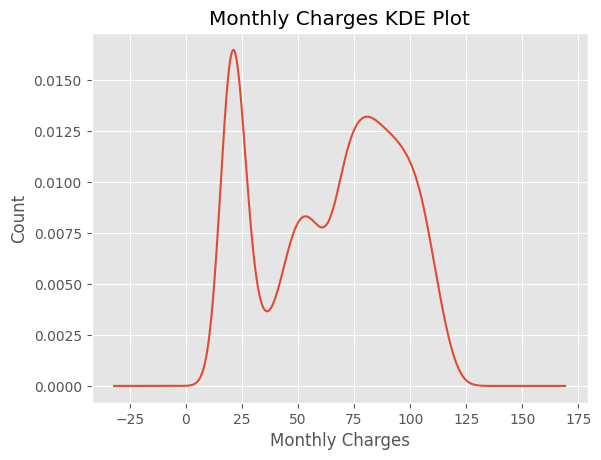

In [17]:
ax = df['Monthly Charges'].plot(kind='kde',
                           title='Monthly Charges KDE Plot')
ax.set_xlabel('Monthly Charges')
ax.set_ylabel('Count')
plt.show()

- We can see three distinct payment bands for monthly charges
    - Roughly 18, 55 and 80

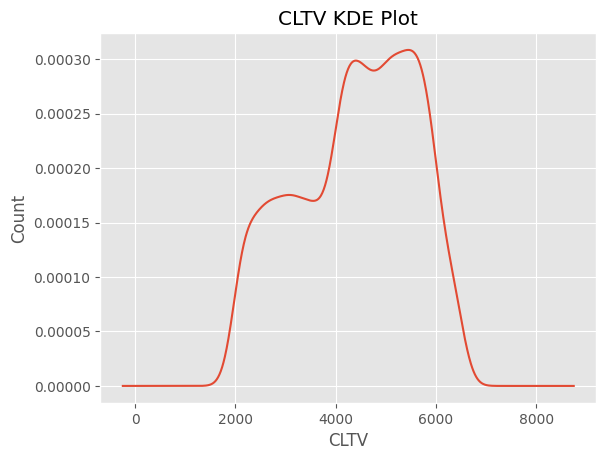

In [18]:
ax = df['CLTV'].plot(kind='kde',
                           title='CLTV KDE Plot')
ax.set_xlabel('CLTV')
ax.set_ylabel('Count')
plt.show()

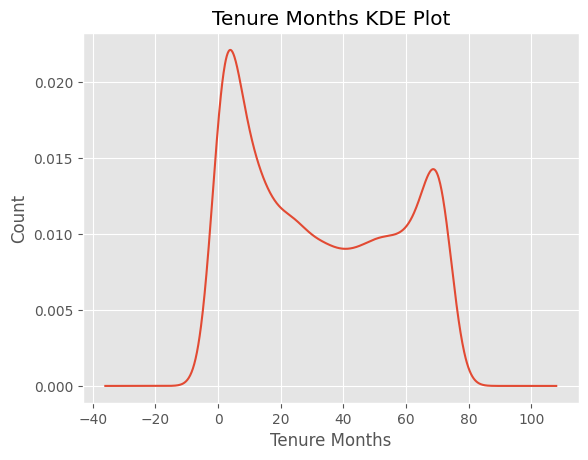

In [19]:
ax = df['Tenure Months'].plot(kind='kde',
                           title='Tenure Months KDE Plot')
ax.set_xlabel('Tenure Months')
ax.set_ylabel('Count')
plt.show()

- Interesting two peaks indicating most common monthly tenure when customers churn
    - Would be wise to target customers just before they reach these tenures to ensure they are happy to improve retention
- If we try to plot Total Charges KDE we get an error:
    - Looks like there are some na values in the total charges column, represented as a space " "
    - We are going to have to deal with this column somehow

In [20]:
# Check if there are other columns with this problem
for col in df.columns:
    if len(df[df[col]==" "]) > 0:
        print(col)

Total Charges


In [21]:
# Take a look at these rows

df[df['Total Charges']==" "].T


,2234,2438,2568,2667,2856,4331,4687,5104,5719,6772,6840
City,San Bernardino,Independence,San Mateo,Cupertino,Redcrest,Los Angeles,Sun City,Ben Lomond,La Verne,Bell,Wilmington
Latitude,34.084909,36.869584,37.590421,37.306612,40.363446,34.089953,33.739412,37.078873,34.144703,33.970343,33.782068
Longitude,-117.258107,-118.189241,-122.306467,-122.080621,-123.835041,-118.294824,-117.173334,-122.090386,-117.770299,-118.171368,-118.262263
Gender,Female,Male,Female,Male,Female,Male,Male,Female,Male,Female,Male
Senior Citizen,0,0,0,0,0,0,0,0,0,0,0
Partner,1,0,1,1,1,1,1,1,1,1,0
Dependents,0,0,0,1,0,1,1,1,1,1,1
Tenure Months,0,0,0,0,0,0,0,0,0,0,0
Phone Service,0,1,1,1,0,1,1,1,1,1,1
Multiple Lines,0,0,0,1,0,0,1,0,0,1,1


In [22]:
df[df['Tenure Months']==0].T

,2234,2438,2568,2667,2856,4331,4687,5104,5719,6772,6840
City,San Bernardino,Independence,San Mateo,Cupertino,Redcrest,Los Angeles,Sun City,Ben Lomond,La Verne,Bell,Wilmington
Latitude,34.084909,36.869584,37.590421,37.306612,40.363446,34.089953,33.739412,37.078873,34.144703,33.970343,33.782068
Longitude,-117.258107,-118.189241,-122.306467,-122.080621,-123.835041,-118.294824,-117.173334,-122.090386,-117.770299,-118.171368,-118.262263
Gender,Female,Male,Female,Male,Female,Male,Male,Female,Male,Female,Male
Senior Citizen,0,0,0,0,0,0,0,0,0,0,0
Partner,1,0,1,1,1,1,1,1,1,1,0
Dependents,0,0,0,1,0,1,1,1,1,1,1
Tenure Months,0,0,0,0,0,0,0,0,0,0,0
Phone Service,0,1,1,1,0,1,1,1,1,1,1
Multiple Lines,0,0,0,1,0,0,1,0,0,1,1


- It looks like newly signed customers with a 'Tenure Months' = 0 do not have a total charge yet
- Given these customers are the same customers with a tenure of 0 months, we can make total charges the same as monthly charge

In [23]:
# Proceed and make the total charges equal to the monthly charges
df['Total Charges'] = df.apply(lambda row: row['Monthly Charges'] if row['Total Charges'] == " " else row['Total Charges'], axis=1)


In [24]:
# Check if there are any values with a string still
df[df['Total Charges']==" "]

,City,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,CLTV,Churn Reason


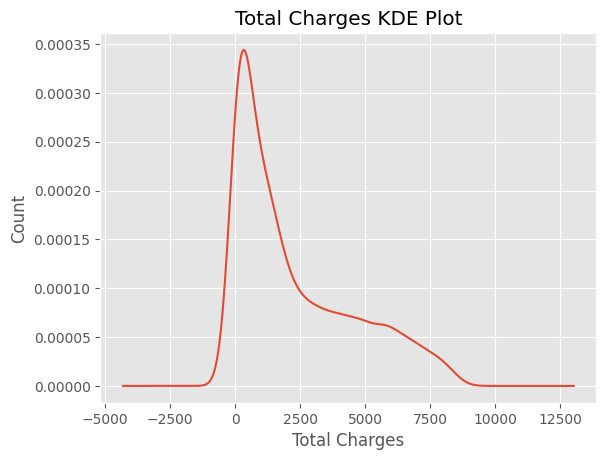

In [25]:
ax = df['Total Charges'].plot(kind='kde',
                           title='Total Charges KDE Plot')
ax.set_xlabel('Total Charges')
ax.set_ylabel('Count')
plt.show()

- Curve as expected
- The higher total charges, the longer a customer has been with the compnay
- Customers leave before they can accumulate significant total charge
    - This is evident in the decline in numbers for large total charges

Text(0.5, 0, 'Count')

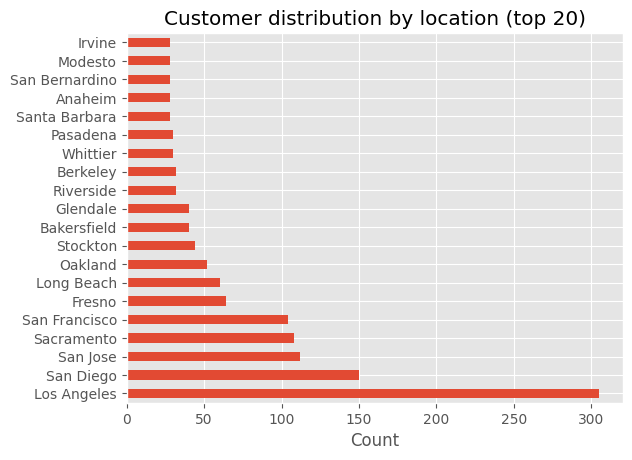

In [26]:
# Look at the customer distribution of customers for the top 20 cities
ax = df['City'].value_counts().head(20).plot(kind='barh',
                                             title='Customer distribution by location (top 20)')
ax.set_xlabel('Count')

In [27]:
df.columns

Index(['City', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner',
       'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines',
       'Internet Service', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges',
       'Total Charges', 'Churn Label', 'CLTV', 'Churn Reason'],
      dtype='object')

Text(0.5, 0, 'Count')

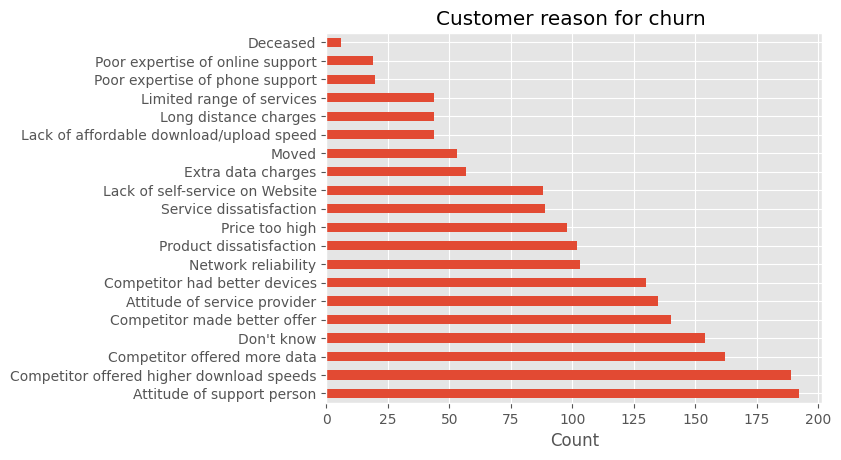

In [28]:
# Look at the distribution of reasons for churn
# Exclude the 'No reason given' option and is it will outswamp all the other values
ax = df['Churn Reason'].value_counts().tail(20).plot(kind='barh',
                                             title='Customer reason for churn ')
ax.set_xlabel('Count')

- Interesting insight into why customers churn
- Improving customer support could increase retention of many customers
- Recommended to put investment into customer support team
- It is also evident that competitors are offering many customers better packages in both finanical and technical aspects

Text(0.5, 0, 'Count')

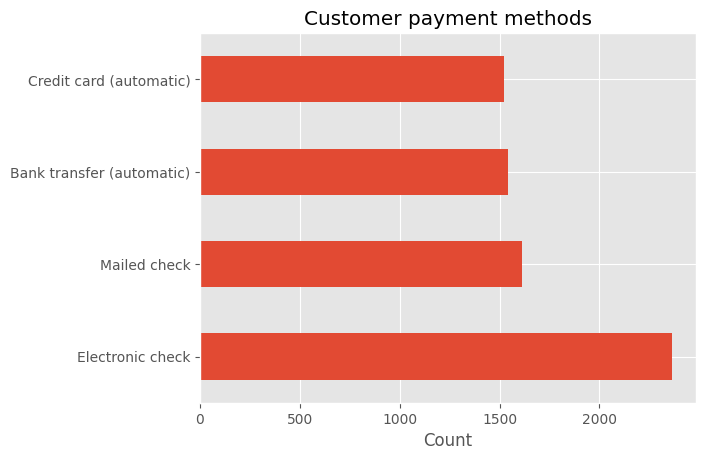

In [29]:
# Look at the distribution of customer payment methods
ax = df['Payment Method'].value_counts().plot(kind='barh',
                                             title='Customer payment methods')
ax.set_xlabel('Count')

Text(0.5, 0, 'Count')

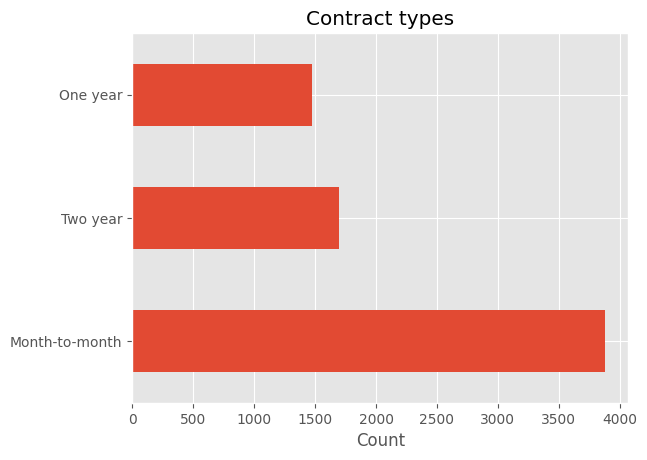

In [30]:
# Look at the distribution of contract types
ax = df['Contract'].value_counts().plot(kind='barh',
                                             title='Contract types')
ax.set_xlabel('Count')

- Significantly more month-to-month contracts

Text(0.5, 0, 'Count')

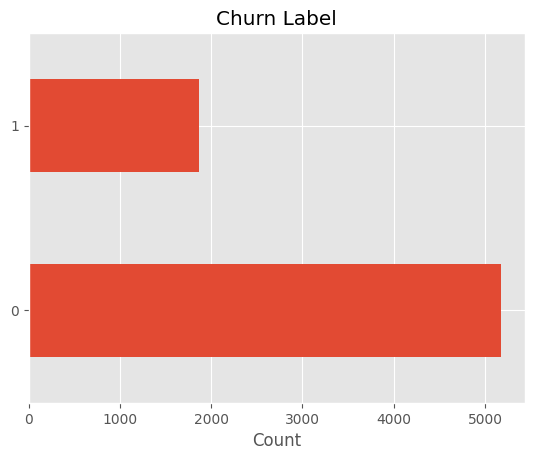

In [31]:
# Look at the distribution of churn labels

ax = df['Churn Label'].value_counts().plot(kind='barh',
                                             title='Churn Label')
ax.set_xlabel('Count')

- Imbalanced dataset - stratify upon train/test split and oversample the training set

## Step 4: Feature Relationships
### Multi-variate relationships
- The goal of this section is to investigate the relationships between different features and the target

/tmp/ipykernel_21/1016194285.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, ax=ax)


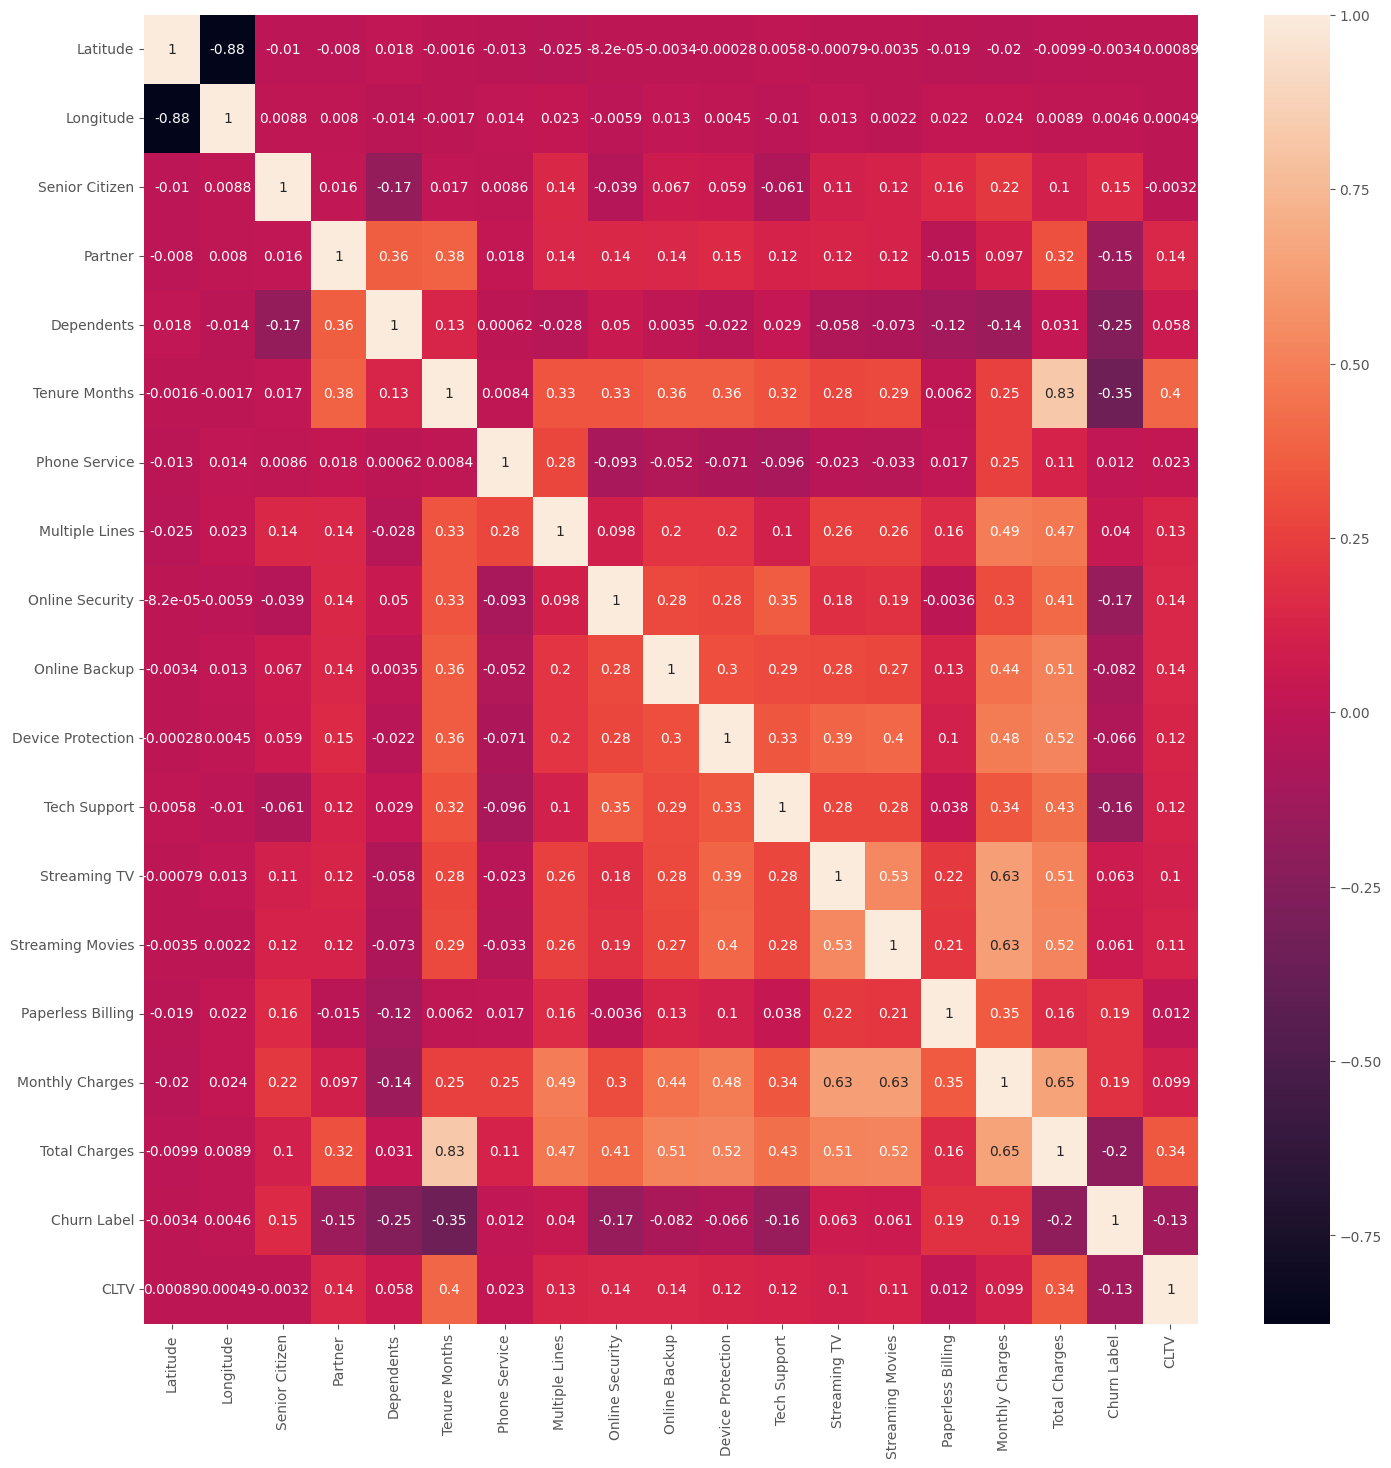

In [32]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(17,17))
sns.heatmap(df.corr(), annot=True, ax=ax)
plt.show()

- There are no obvious features to drop due to high correlation with one another


/tmp/ipykernel_21/1053568703.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = df.corr()['Churn Label'].plot(kind='barh')


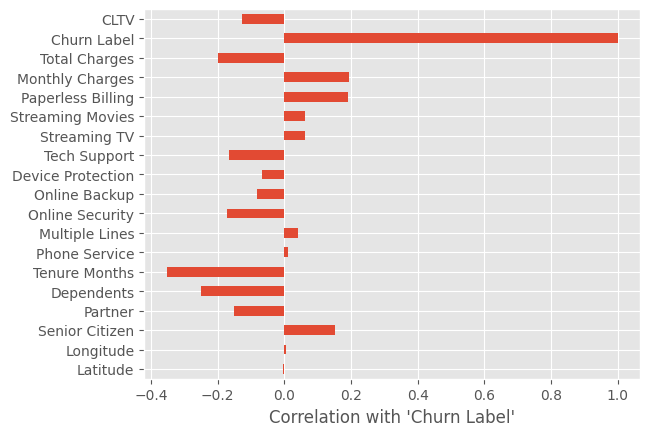

In [33]:
# Let's visualise correlation with the target column in a clearer way
plt.figure()
ax = df.corr()['Churn Label'].plot(kind='barh')
ax.set_xlabel("Correlation with 'Churn Label'")
plt.show()

- Some features have very small correlation with target column but we will keep them for now
- Feature selection will be evaluated later on

In [34]:
df.columns, numerical_columns, categorical_columns
#print(len(df.columns), len(numerical_columns), len(categorical_columns))

(Index(['City', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner',
        'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines',
        'Internet Service', 'Online Security', 'Online Backup',
        'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
        'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges',
        'Total Charges', 'Churn Label', 'CLTV', 'Churn Reason'],
       dtype='object'),
 ['Latitude',
  'Total Charges',
  'Tenure Months',
  'CLTV',
  'Monthly Charges',
  'Longitude'],
 ['Gender',
  'Senior Citizen',
  'Partner',
  'Dependents',
  'Phone Service',
  'Multiple Lines',
  'Internet Service',
  'Online Security',
  'Online Backup',
  'Device Protection',
  'Tech Support',
  'Streaming TV',
  'Streaming Movies',
  'Contract',
  'Paperless Billing',
  'Payment Method',
  'Churn Label',
  'City',
  'Churn Reason'])

/tmp/ipykernel_21/1504119052.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


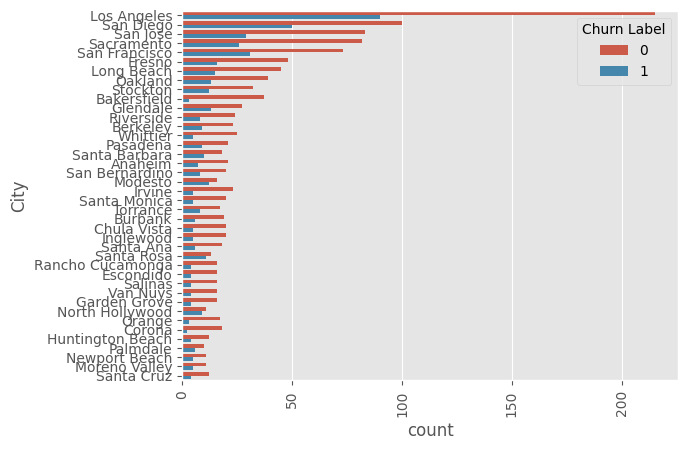

In [35]:
# Churners by city
top_categories = df['City'].value_counts().head(40).index
df_filtered = df[df['City'].isin(top_categories)]

ax = sns.countplot(data=df_filtered, y='City', order=top_categories, hue='Churn Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

- Shows us how the % of churners changes for each city
- Some cities have significantly higher % of churners
- Useful to know which cities to target to reduce high churn rates
- From a machine learning perspective:
    - Create a feature, % churn by city as may be useful for fitting an ml model

In [36]:
# Let's create this new feature
df['Churn_%_by_city'] = df.groupby('City')['Churn Label'].transform(lambda x: x.sum()/ x.count() if x.sum()>0 else 0)

In [37]:
# Let's just rename all columns to replace ' ' with '_'
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['City', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen', 'Partner',
       'Dependents', 'Tenure_Months', 'Phone_Service', 'Multiple_Lines',
       'Internet_Service', 'Online_Security', 'Online_Backup',
       'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies',
       'Contract', 'Paperless_Billing', 'Payment_Method', 'Monthly_Charges',
       'Total_Charges', 'Churn_Label', 'CLTV', 'Churn_Reason',
       'Churn_%_by_city'],
      dtype='object')

<AxesSubplot: xlabel='Latitude', ylabel='Longitude'>

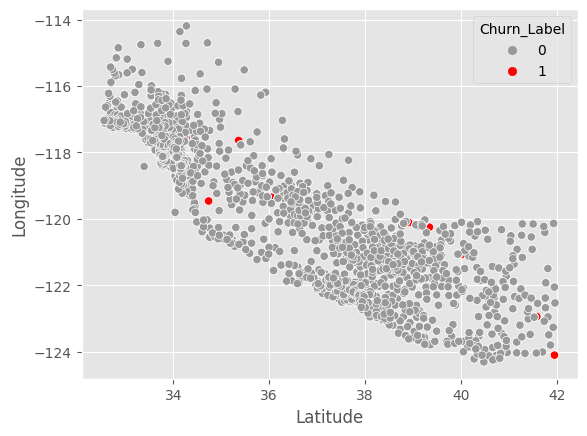

In [38]:
# Geographical distribution of churners
sns.scatterplot(data=df, y='Longitude', x='Latitude', hue='Churn_Label', palette =["#999999", "#FF0000"]  )

/tmp/ipykernel_21/2144645599.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


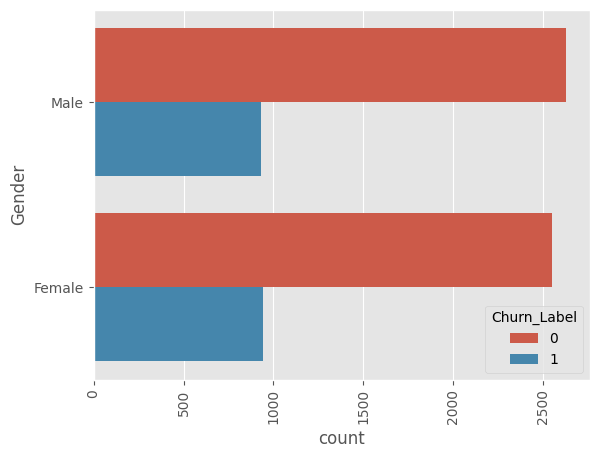

In [39]:
# Churners by gender
top_categories = df['Gender'].value_counts().index
df_filtered = df[df['Gender'].isin(top_categories)]

ax = sns.countplot(data=df_filtered, y='Gender', order=top_categories, hue='Churn_Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

- Can see that churn is pretty much independent of gender

/tmp/ipykernel_21/937763365.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


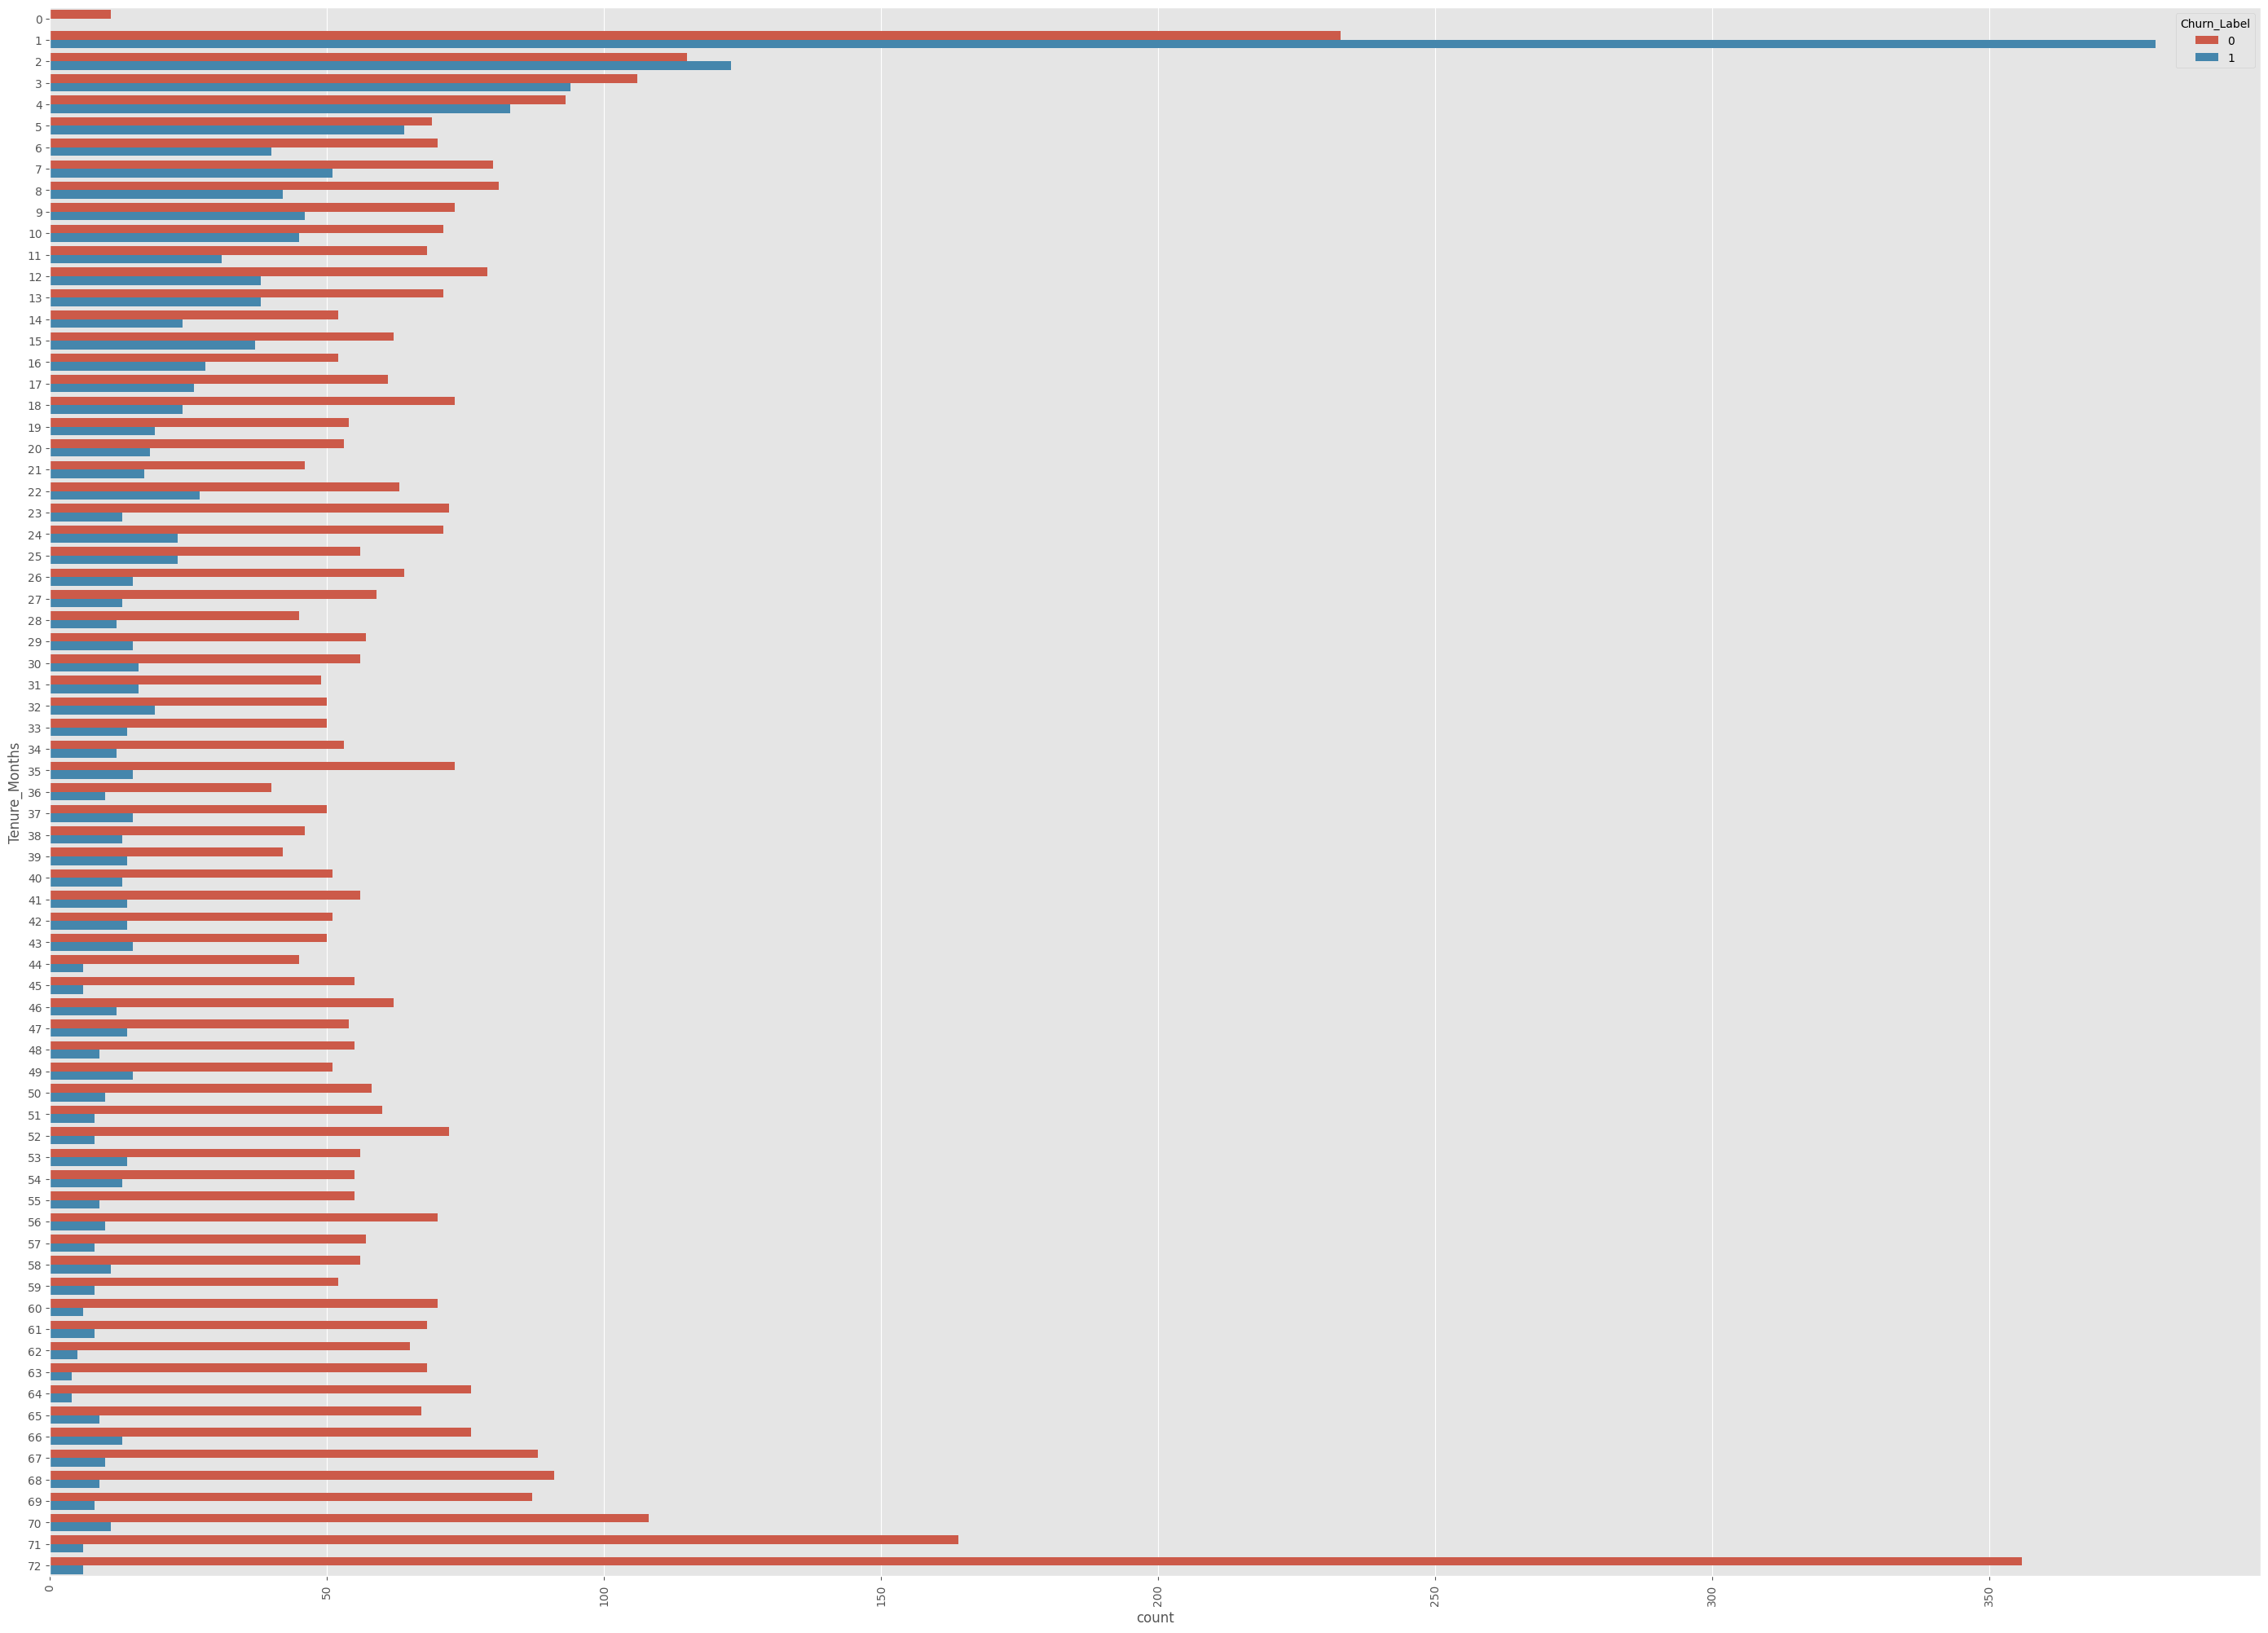

In [40]:
# Churners by Tenure
top_categories = df['Tenure_Months'].value_counts().index
df_filtered = df[df['Tenure_Months'].isin(top_categories)]
sorted_categories = df_filtered['Tenure_Months'].sort_values().unique()

plt.figure(figsize=(35,25))
ax = sns.countplot(data=df_filtered, y='Tenure_Months', order=sorted_categories, hue='Churn_Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

- Shows an inverse relationship between number of months and likelihood of churn
- Introduce % churn by tenure

In [41]:
# Let's create this new feature
df['Churn_%_by_tenure'] = df.groupby('Tenure_Months')['Churn_Label'].transform(lambda x: x.sum()/x.count())


/tmp/ipykernel_21/1564889426.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


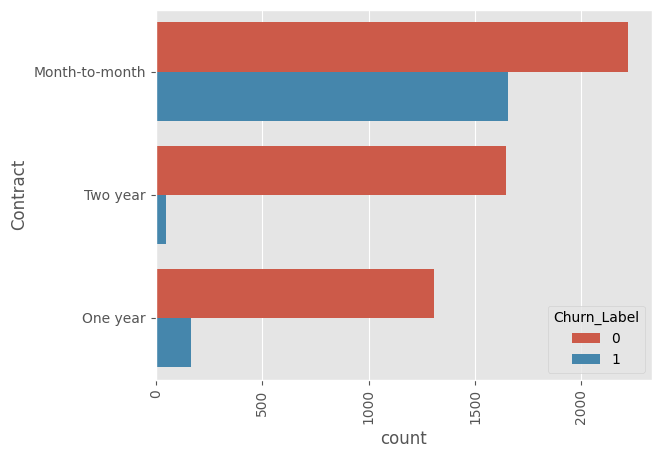

In [42]:
# Churners by contract
top_categories = df['Contract'].value_counts().index
df_filtered = df[df['Contract'].isin(top_categories)]

ax = sns.countplot(data=df_filtered, y='Contract', order=top_categories, hue='Churn_Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

- Shows us that churn % is much higer for the month-to-month
    - It may be an easy way to bring customers on board but it is also an easy way to lose them!
    - Maybe alternative strategies need to be explored or more rigourous customer service for the month-to-month customers as they make up the majority of customers!!
- Introduce % churn per contract as a feature

In [43]:
# Let's create this new feature
df['Churn_%_by_contract'] = df.groupby('Contract')['Churn_Label'].transform(lambda x: x.sum()/x.count())


In [44]:
df.columns

Index(['City', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen', 'Partner',
       'Dependents', 'Tenure_Months', 'Phone_Service', 'Multiple_Lines',
       'Internet_Service', 'Online_Security', 'Online_Backup',
       'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies',
       'Contract', 'Paperless_Billing', 'Payment_Method', 'Monthly_Charges',
       'Total_Charges', 'Churn_Label', 'CLTV', 'Churn_Reason',
       'Churn_%_by_city', 'Churn_%_by_tenure', 'Churn_%_by_contract'],
      dtype='object')

/tmp/ipykernel_21/1409341886.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


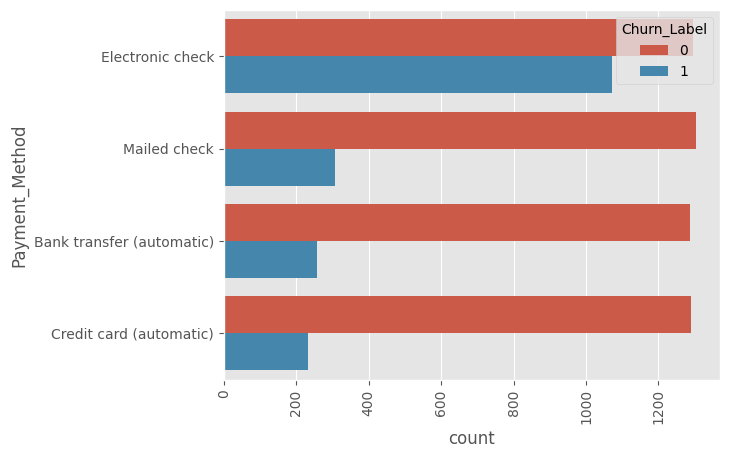

In [45]:
# Churners by payment method
top_categories = df['Payment_Method'].value_counts().index
df_filtered = df[df['Payment_Method'].isin(top_categories)]

plt.figure()
ax = sns.countplot(data=df_filtered, y='Payment_Method', order=top_categories, hue='Churn_Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

- Shows us that an electronic check means it is significantly more likely for a customer to churn
    - Telco should encourage customers to set-up automatic direct debits instead! 
- Add % churn by payment method as a feature

In [46]:
# Let's add this feature
df['Churn_%_by_payment_method'] = df.groupby('Payment_Method')['Churn_Label'].transform(lambda x: x.sum()/x.count())
df


,City,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,...,Payment_Method,Monthly_Charges,Total_Charges,Churn_Label,CLTV,Churn_Reason,Churn_%_by_city,Churn_%_by_tenure,Churn_%_by_contract,Churn_%_by_payment_method
0,Los Angeles,33.964131,-118.272783,Male,0,0,0,2,1,0,...,Mailed check,53.85,108.15,1,3239,Competitor made better offer,0.295082,0.516807,0.427097,0.191067
1,Los Angeles,34.059281,-118.307420,Female,0,0,1,2,1,0,...,Electronic check,70.70,151.65,1,2701,Moved,0.295082,0.516807,0.427097,0.452854
2,Los Angeles,34.048013,-118.293953,Female,0,0,1,8,1,1,...,Electronic check,99.65,820.50,1,5372,Moved,0.295082,0.341463,0.427097,0.452854
3,Los Angeles,34.062125,-118.315709,Female,0,1,1,28,1,1,...,Electronic check,104.80,3046.05,1,5003,Moved,0.295082,0.210526,0.427097,0.452854
4,Los Angeles,34.039224,-118.266293,Male,0,0,1,49,1,1,...,Bank transfer (automatic),103.70,5036.30,1,5340,Competitor had better devices,0.295082,0.227273,0.427097,0.167098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Landers,34.341737,-116.539416,Female,0,0,0,72,1,0,...,Bank transfer (automatic),21.15,1419.40,0,5306,No answer,0.200000,0.016575,0.028319,0.167098
7039,Adelanto,34.667815,-117.536183,Male,0,1,1,24,1,1,...,Mailed check,84.80,1990.50,0,2140,No answer,0.200000,0.244681,0.112695,0.191067
7040,Amboy,34.559882,-115.637164,Female,0,1,1,72,1,1,...,Credit card (automatic),103.20,7362.90,0,5560,No answer,0.200000,0.016575,0.112695,0.152431
7041,Angelus Oaks,34.167800,-116.864330,Female,0,1,1,11,0,0,...,Electronic check,29.60,346.45,0,2793,No answer,0.400000,0.313131,0.427097,0.452854


In [47]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042
City,Los Angeles,Los Angeles,Los Angeles,Los Angeles,Los Angeles,Los Angeles,Los Angeles,Los Angeles,Los Angeles,Los Angeles,...,Twentynine Palms,Twentynine Palms,Westmorland,Winterhaven,Yucca Valley,Landers,Adelanto,Amboy,Angelus Oaks,Apple Valley
Latitude,33.964131,34.059281,34.048013,34.062125,34.039224,34.066367,34.02381,34.066303,34.099869,34.089953,...,34.17211,34.457829,33.03679,32.852947,34.159534,34.341737,34.667815,34.559882,34.1678,34.424926
Longitude,-118.272783,-118.30742,-118.293953,-118.315709,-118.266293,-118.309868,-118.156582,-118.435479,-118.326843,-118.294824,...,-115.769773,-116.139589,-115.60503,-114.850784,-116.425984,-116.539416,-117.536183,-115.637164,-116.86433,-117.184503
Gender,Male,Female,Female,Female,Male,Female,Male,Male,Male,Male,...,Female,Male,Male,Male,Female,Female,Male,Female,Female,Male
Senior_Citizen,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Partner,0,0,0,1,0,1,0,0,1,1,...,0,1,0,0,0,0,1,1,1,0
Dependents,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,1,1,1,0
Tenure_Months,2,2,8,28,49,10,1,1,47,1,...,2,55,38,19,12,72,24,72,11,66
Phone_Service,1,1,1,1,1,1,0,1,1,0,...,1,1,1,1,0,1,1,1,0,1
Multiple_Lines,0,0,1,1,1,0,0,0,1,0,...,0,1,0,0,0,0,1,1,0,0


In [48]:
# Create an 'Other' bucket for cities not in the top 20 
df['City'] = df['City'].apply(lambda x: x if x in df['City'].value_counts().head(20).index else "Other")   


In [49]:
len(df['Gender'].value_counts())

2

In [50]:
# Let's do a plot with all binary features and see how they impact churn'
binary_features = [feature for feature in df.columns if (len(df[feature].value_counts()) == 2) and (feature != 'Churn_Label')]
binary_features

['Gender',
 'Senior_Citizen',
 'Partner',
 'Dependents',
 'Phone_Service',
 'Multiple_Lines',
 'Online_Security',
 'Online_Backup',
 'Device_Protection',
 'Tech_Support',
 'Streaming_TV',
 'Streaming_Movies',
 'Paperless_Billing']

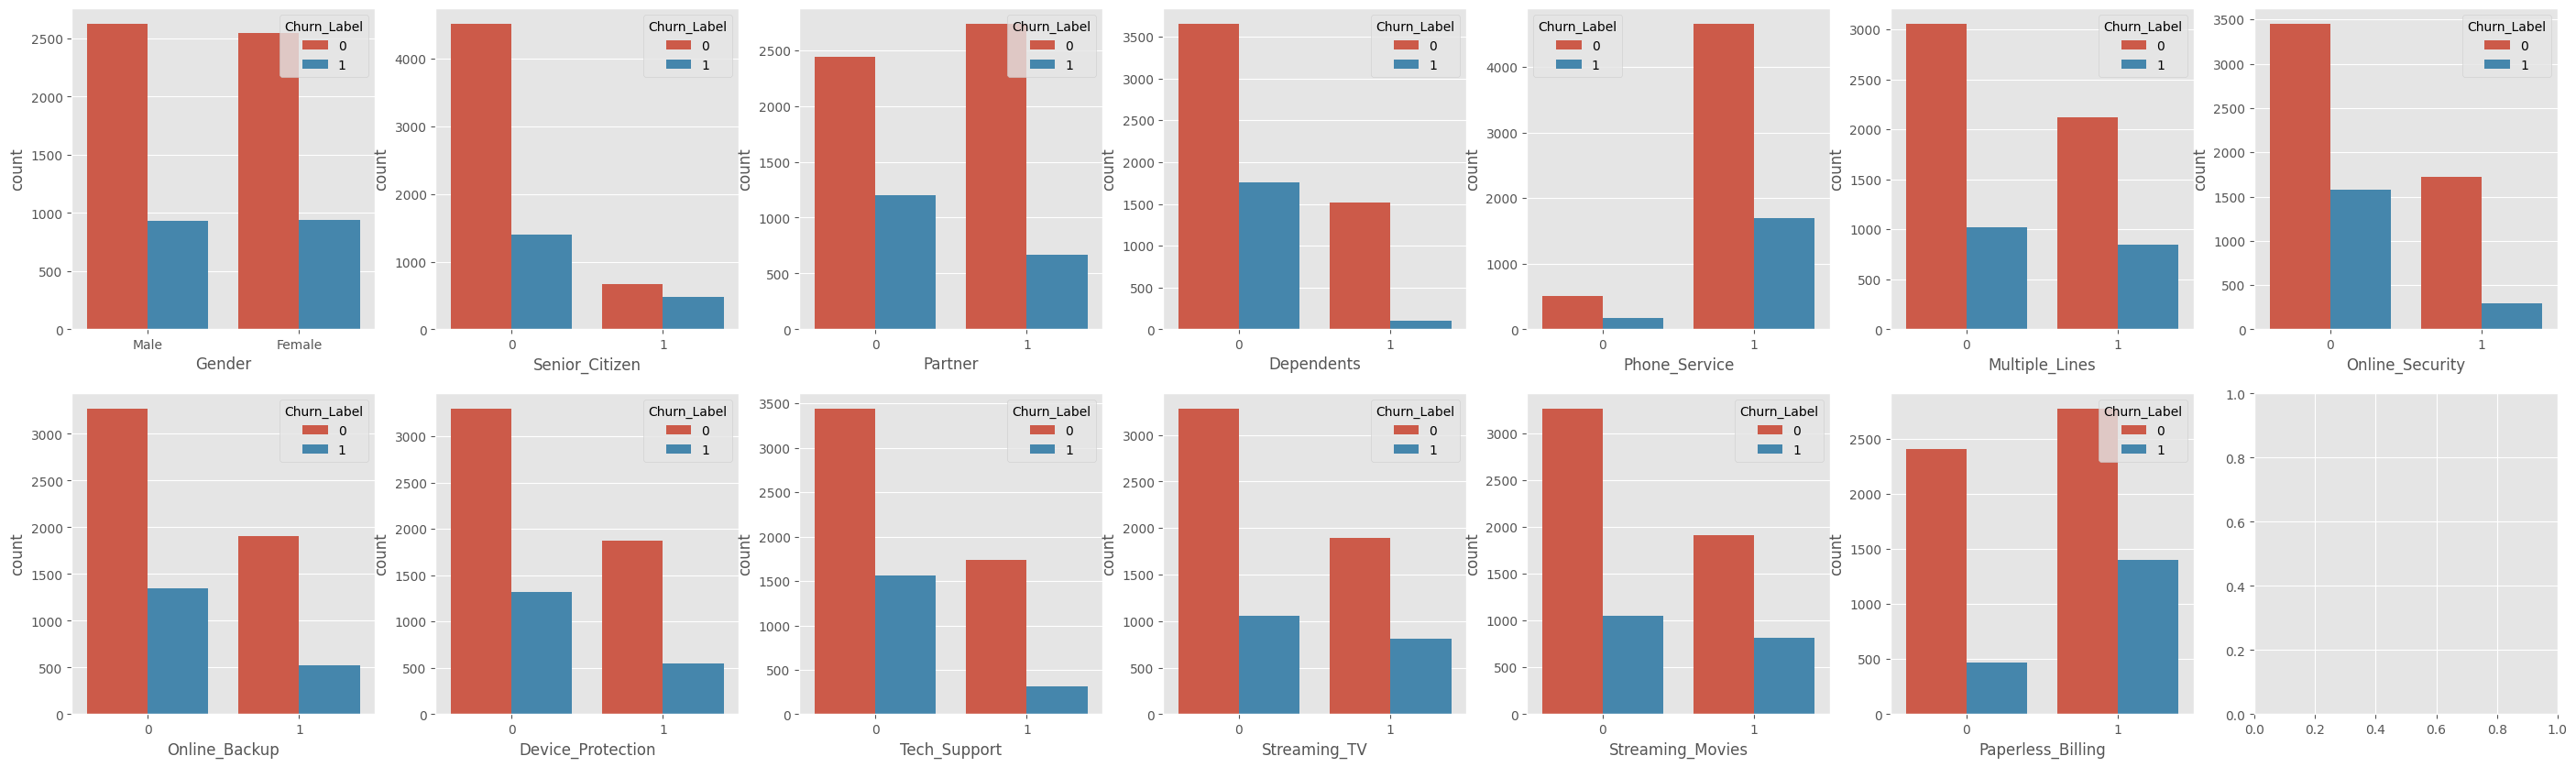

In [51]:
# Let's make a big plot of all of these with Churn Label as the hue
fig, ax = plt.subplots(nrows=2, ncols=len(binary_features)//2 + 1, figsize=(35,10))
for idx, feature in enumerate(binary_features):
    sns.countplot(data=df, x=feature, hue='Churn_Label', ax=ax[idx //7, idx % 7])
    
plt.show()

### Okay lets break these down one by one:
- Gender
    - As previously established, no significant relationship
- Senior Citizen
    - Churn rate amongst Senior Citizens significantly higher
- Has partner
    - Churn rate higher for people without a partner
- Dependents
    - Churn rate significantly lower for people with dependents
- Phone service
    - Two categroies are too disparate to draw meaningful conclusions, I'm wondering why people with no phone service even signed up in the first place
- Multiple lines
    - Higher churn rate for customers with multiple lines
- Online security
    - People with online security have much lower churn rates
- Online backup
    - People with online backup have much lower churn rates
- Device protection
    - People with device protection have much lower churn rates
- Tech support
    - People without tech support churn at a much higher rate
- Streaming
    - People with streaming capabilites are more likely to churn
    - Interesting insight - maybe people who priorities streaming are receiving a better deal elsewhere - should be investigated!
- Paperless billing
    - Paperless billing gives a much higher churn rate

/tmp/ipykernel_21/1008811574.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


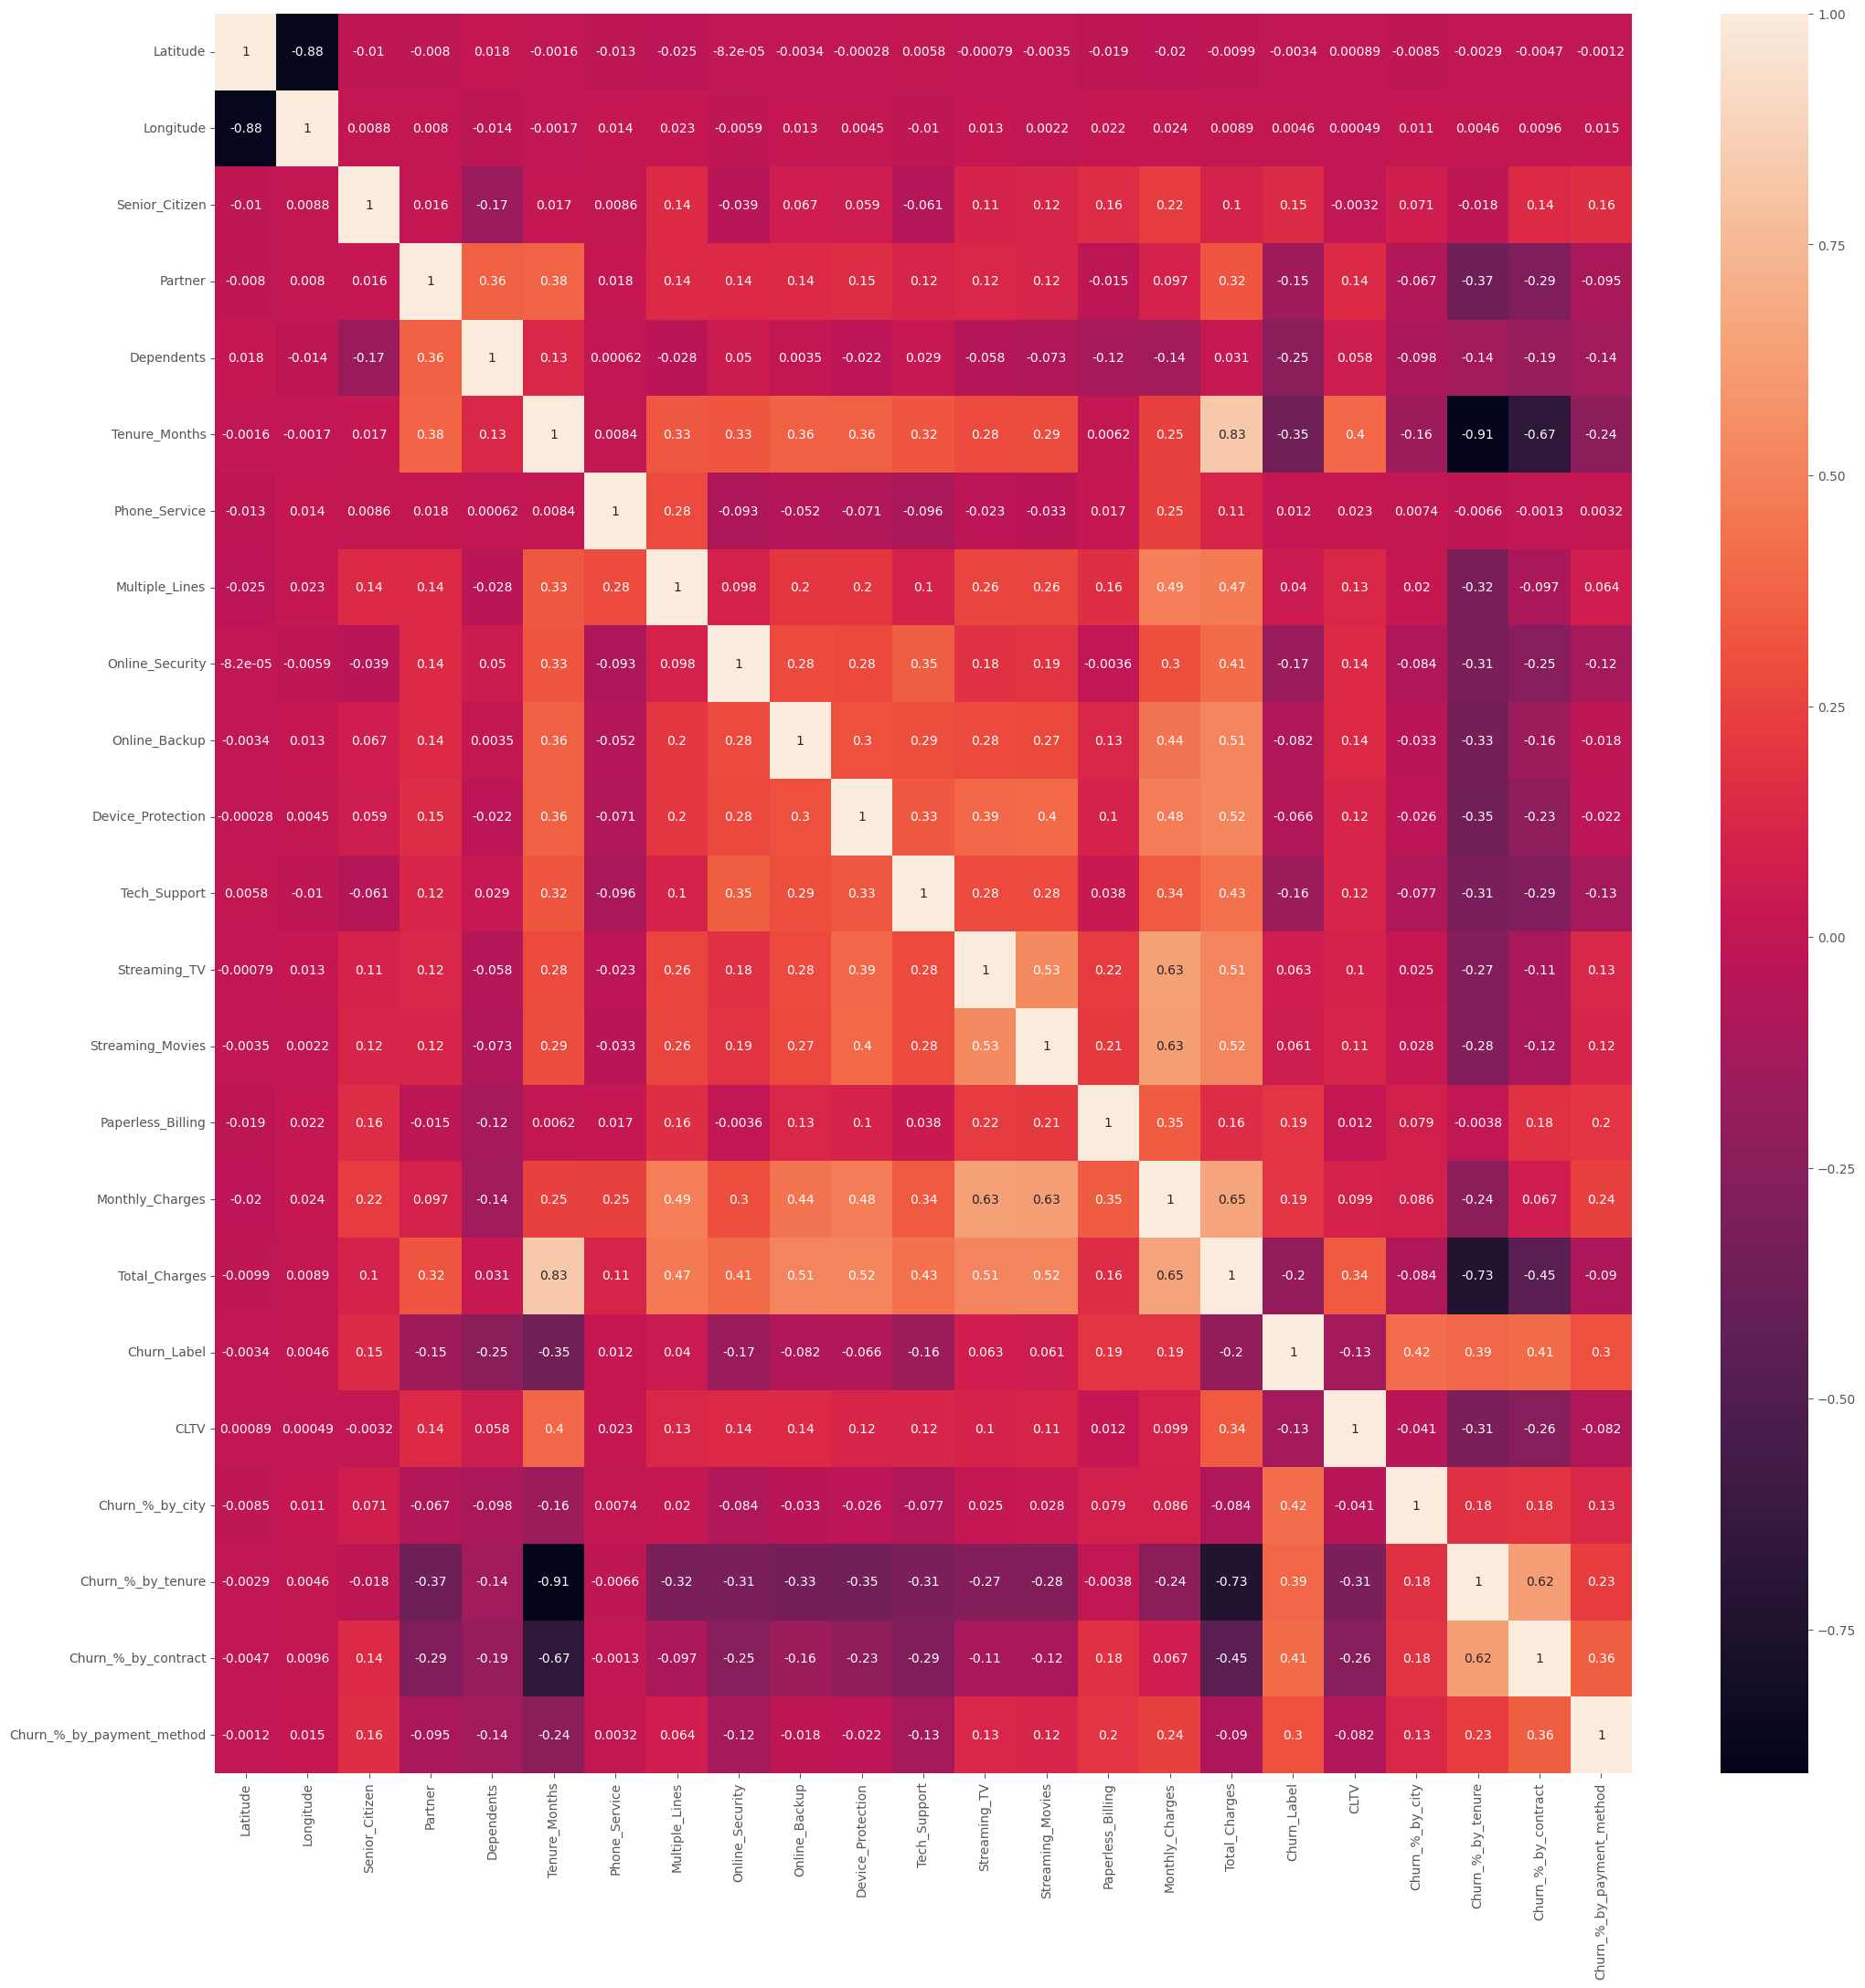

In [52]:
# Take a look ata final heatmap to ensure we've not missed any obvious drops
plt.figure(figsize=(25,25))
sns.heatmap(df.corr(), annot=True)
plt.show()

## Step 5: Model Fitting and Feature Selection
### I will be using f1 score as the evaluation metric due to the imbalance in the dataset 

In [53]:
# Initial imports
from lightgbm import LGBMClassifier
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [54]:
# Separate the features and the target columns
X = df.drop(['Churn_Label','Churn_Reason'], axis=1) # Must drop Churn_Reason as it directly indicates a customer churning
y = df['Churn_Label']
X.columns

Index(['City', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen', 'Partner',
       'Dependents', 'Tenure_Months', 'Phone_Service', 'Multiple_Lines',
       'Internet_Service', 'Online_Security', 'Online_Backup',
       'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies',
       'Contract', 'Paperless_Billing', 'Payment_Method', 'Monthly_Charges',
       'Total_Charges', 'CLTV', 'Churn_%_by_city', 'Churn_%_by_tenure',
       'Churn_%_by_contract', 'Churn_%_by_payment_method'],
      dtype='object')

In [55]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42,
                                                    shuffle=True)

In [56]:
# Encode categorical columns
# Note: I have done scaling to consider non-tree models but it is not necessary for tree based models
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Create column transformer object with OneHotEncoder
ct = ColumnTransformer(
[
    ("ohe", OneHotEncoder(drop='first',sparse_output=False), ['City', 'Gender', 'Internet_Service', 'Contract', 'Payment_Method']),
    ("ss", StandardScaler(), ['Latitude', 'Longitude', 'Tenure_Months', 'Monthly_Charges', 'Total_Charges', 'CLTV', 'Churn_%_by_city', 
                              'Churn_%_by_tenure', 'Churn_%_by_contract', 'Churn_%_by_payment_method'])
],
remainder='passthrough'
)

# Transform the training and test sets
X_train_enc = ct.fit_transform(X_train)
X_test_enc = ct.transform(X_test)

# Convert numpy arrays to pandas dataframes 
feature_names = ct.get_feature_names_out()
X_train_enc = pd.DataFrame(X_train_enc, columns=feature_names)
X_test_enc = pd.DataFrame(X_test_enc, columns=feature_names)

In [57]:
from imblearn.over_sampling import SMOTE

# Over sample the training set as we have an imbalanced dataset
over_sampler = SMOTE(sampling_strategy=1)
X_train_enc, y_train = over_sampler.fit_resample(X_train_enc, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.6, 0.7)

<Figure size 640x480 with 0 Axes>

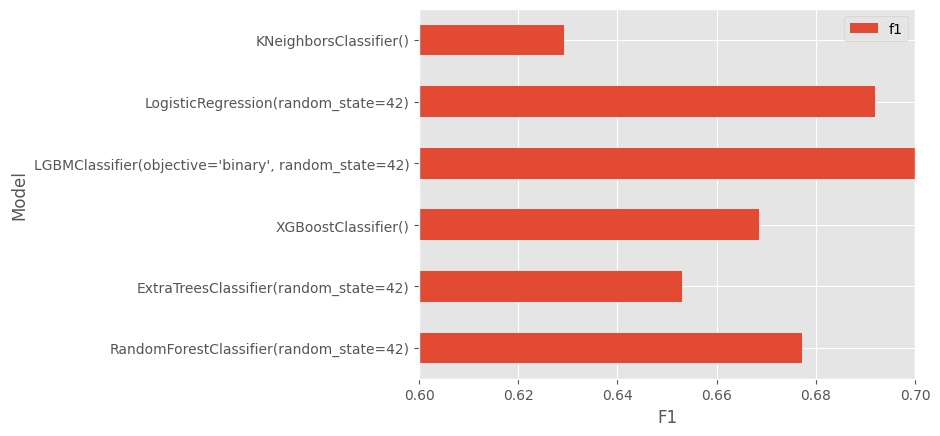

In [58]:
# Test base models
from typing import List
def run_models(models: List):
    results = []
    for model in models:
        ind_model_result = {}
        clf = model
        clf.fit(X_train_enc, y_train)
        y_pred = model.predict(X_test_enc)
        ind_model_result['Accuracy'] = accuracy_score(y_test, y_pred)
        ind_model_result['Precison'] = precision_score(y_test, y_pred)
        ind_model_result['f1-score'] = f1_score(y_test, y_pred)
        ind_model_result['Name'] = 'XGBoostClassifier()' if f"{model}"[0] == 'X' else f"{model}"
        results.append(ind_model_result)
    return results
        
results = run_models([RandomForestClassifier(random_state=42), ExtraTreesClassifier(random_state=42), XGBClassifier(random_state=42), 
                      LGBMClassifier(objective='binary', random_state=42), LogisticRegression(random_state=42), KNeighborsClassifier()])
results

f1_list = [dictionary['f1-score'] for dictionary in results]
model_list = [dictionary['Name'] for dictionary in results ]
model_dataframe = pd.DataFrame({'model_name': model_list, 'f1':f1_list})
plt.figure()
ax = model_dataframe.plot(kind='barh', x='model_name', y='f1')
ax.set_xlabel('F1')
ax.set_ylabel('Model')
ax.set_xlim([0.6, 0.7])

 ### I am going to use the LightGBM model due to it's speed in training and hyperparameter optimisation 

In [59]:
# Try fitting LGBM with an early stopping round implemented
clf = LGBMClassifier(
                     n_estimators=20000,
                     learning_rate=0.01,
                     random_state=42)

eval_set = [(X_test_enc, y_test)]

clf.fit(X_train_enc,
        y_train,
        eval_set=eval_set,
        callbacks=[lightgbm.early_stopping(stopping_rounds=200)],
        eval_metric="cross_entropy_lambda")

y_pred = clf.predict(X_test_enc)
f1 = f1_score(y_test, y_pred)
print(f"The f1 score is now: {f1}")


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[484]	valid_0's cross_entropy_lambda: 0.363009	valid_0's binary_logloss: 0.341782
The f1 score is now: 0.7087628865979382


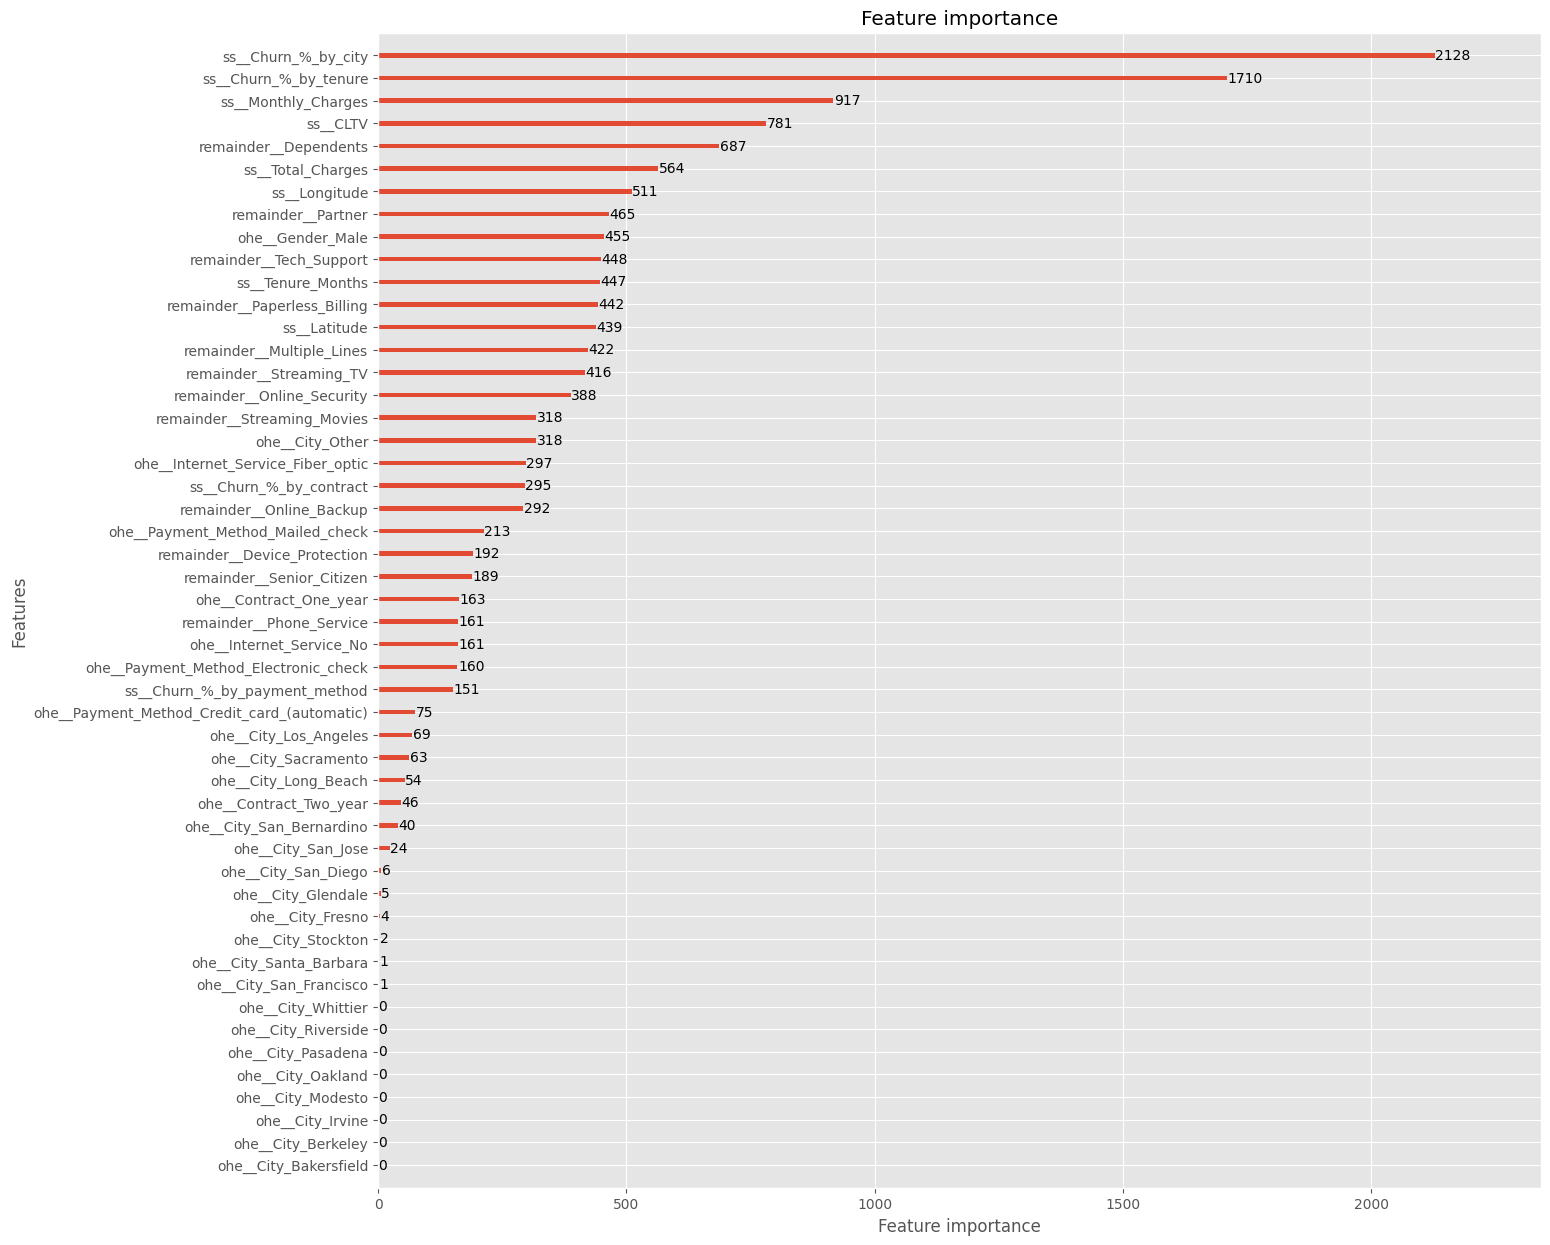

In [60]:
# Analyse the feature importances
ax = lightgbm.plot_importance(clf, ignore_zero=False, figsize=(15,15))
plt.show()

- There are many (17) features contributing 0 to the model, so we can drop these features

In [61]:
# Create a list with the features to drop and then drop these features
features_to_drop = [feature for feature, value in zip(X_train_enc.columns, clf.feature_importances_) if value == 0]
X_train_enc = X_train_enc.drop(columns=features_to_drop)
X_test_enc = X_test_enc.drop(columns=features_to_drop)


In [62]:
# Refit the model and see if there is any change in f1 score
# Try fitting LGBM with an early stopping round implemented
clf = LGBMClassifier(objective="binary",
                     n_estimators=20000,
                     learning_rate=0.01,
                     random_state=42)

eval_set = [(X_test_enc, y_test)]

clf.fit(X_train_enc,
        y_train,
        eval_set=eval_set,
        callbacks=[lightgbm.early_stopping(stopping_rounds=200)],
        eval_metric="binary_logloss")

y_pred = clf.predict(X_test_enc)
f1_post_feature_removal = f1_score(y_test, y_pred)
print(f"The f1 after features removed is now: {f1_post_feature_removal}")
print(f"The f1 before features were removed was: {f1}")


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[484]	valid_0's binary_logloss: 0.341782
The f1 after features removed is now: 0.7087628865979382
The f1 before features were removed was: 0.7087628865979382


- Dropping those features improves performance

## Step 6: Hyperparameter Tuning (and more feature selection)

In [63]:
# Tune hyperparameters for lightgbm model using the lightgbm tuner 
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, f1_score


dtrain = lgb.Dataset(X_train_enc, y_train)
dval = lgb.Dataset(X_test_enc, y_test)

params = {
    "objective": "binary",
    "metric": "cross_entropy_lambda",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "random_state":42
}

model = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    callbacks=[early_stopping(100), log_evaluation(100)]
)

prediction = np.rint(model.predict(X_test_enc, num_iteration=model.best_iteration))
f1 = f1_score(y_test, prediction)
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
auc = roc_auc_score(y_test, prediction)
acc = accuracy_score(y_test, prediction)

best_params = model.params
print("Best params:", best_params)
print("  F1 Score = {}".format(f1))
print("  Precision = {}".format(precision))
print("  Recall = {}".format(recall))
print("  AUC = {}".format(auc))
print("  Accuracy = {}".format(acc))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))


[I 2023-05-25 14:34:27,965] A new study created in memory with name: no-name-cc875035-7415-4afc-a504-64354205915d
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's cross_entropy_lambda: 0.33135	valid_1's cross_entropy_lambda: 0.367615


feature_fraction, val_score: 0.360484:  14%|#4        | 1/7 [00:01<00:10,  1.70s/it]

Early stopping, best iteration is:
[57]	valid_0's cross_entropy_lambda: 0.365293	valid_1's cross_entropy_lambda: 0.360484
[100]	valid_0's cross_entropy_lambda: 0.336162	valid_1's cross_entropy_lambda: 0.365273


feature_fraction, val_score: 0.360484:  29%|##8       | 2/7 [00:03<00:08,  1.75s/it]

Early stopping, best iteration is:
[57]	valid_0's cross_entropy_lambda: 0.365293	valid_1's cross_entropy_lambda: 0.360484
[100]	valid_0's cross_entropy_lambda: 0.32541	valid_1's cross_entropy_lambda: 0.368998


feature_fraction, val_score: 0.360471:  43%|####2     | 3/7 [00:05<00:06,  1.70s/it]

Early stopping, best iteration is:
[45]	valid_0's cross_entropy_lambda: 0.371095	valid_1's cross_entropy_lambda: 0.360471
[100]	valid_0's cross_entropy_lambda: 0.326725	valid_1's cross_entropy_lambda: 0.371001


feature_fraction, val_score: 0.360471:  57%|#####7    | 4/7 [00:06<00:04,  1.62s/it]

Early stopping, best iteration is:
[45]	valid_0's cross_entropy_lambda: 0.371095	valid_1's cross_entropy_lambda: 0.360471
[100]	valid_0's cross_entropy_lambda: 0.32458	valid_1's cross_entropy_lambda: 0.373445


feature_fraction, val_score: 0.360471:  71%|#######1  | 5/7 [00:08<00:03,  1.53s/it]

Early stopping, best iteration is:
[45]	valid_0's cross_entropy_lambda: 0.371095	valid_1's cross_entropy_lambda: 0.360471
[100]	valid_0's cross_entropy_lambda: 0.324335	valid_1's cross_entropy_lambda: 0.370264


feature_fraction, val_score: 0.360471:  86%|########5 | 6/7 [00:10<00:01,  1.85s/it]

Early stopping, best iteration is:
[45]	valid_0's cross_entropy_lambda: 0.371095	valid_1's cross_entropy_lambda: 0.360471
[100]	valid_0's cross_entropy_lambda: 0.329224	valid_1's cross_entropy_lambda: 0.367931


feature_fraction, val_score: 0.360471: 100%|##########| 7/7 [00:11<00:00,  1.70s/it]


Early stopping, best iteration is:
[45]	valid_0's cross_entropy_lambda: 0.371095	valid_1's cross_entropy_lambda: 0.360471


num_leaves, val_score: 0.360471:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	valid_0's cross_entropy_lambda: 0.282047	valid_1's cross_entropy_lambda: 0.38298


num_leaves, val_score: 0.360471:   5%|5         | 1/20 [00:02<00:50,  2.64s/it]

Early stopping, best iteration is:
[45]	valid_0's cross_entropy_lambda: 0.371095	valid_1's cross_entropy_lambda: 0.360471


num_leaves, val_score: 0.360471:  10%|#         | 2/20 [00:03<00:24,  1.38s/it]

[100]	valid_0's cross_entropy_lambda: 0.3951	valid_1's cross_entropy_lambda: 0.363094
Early stopping, best iteration is:
[45]	valid_0's cross_entropy_lambda: 0.371095	valid_1's cross_entropy_lambda: 0.360471
[100]	valid_0's cross_entropy_lambda: 0.282047	valid_1's cross_entropy_lambda: 0.38298


num_leaves, val_score: 0.360471:  15%|#5        | 3/20 [00:05<00:34,  2.03s/it]

Early stopping, best iteration is:
[45]	valid_0's cross_entropy_lambda: 0.371095	valid_1's cross_entropy_lambda: 0.360471
[100]	valid_0's cross_entropy_lambda: 0.241492	valid_1's cross_entropy_lambda: 0.418373


num_leaves, val_score: 0.360471:  20%|##        | 4/20 [00:12<00:59,  3.72s/it]

Early stopping, best iteration is:
[45]	valid_0's cross_entropy_lambda: 0.371095	valid_1's cross_entropy_lambda: 0.360471


num_leaves, val_score: 0.360471:  25%|##5       | 5/20 [00:12<00:38,  2.58s/it]

[100]	valid_0's cross_entropy_lambda: 0.3951	valid_1's cross_entropy_lambda: 0.363094
Early stopping, best iteration is:
[45]	valid_0's cross_entropy_lambda: 0.371095	valid_1's cross_entropy_lambda: 0.360471
[100]	valid_0's cross_entropy_lambda: 0.245616	valid_1's cross_entropy_lambda: 0.405535


num_leaves, val_score: 0.360471:  30%|###       | 6/20 [00:18<00:51,  3.66s/it]

Early stopping, best iteration is:
[45]	valid_0's cross_entropy_lambda: 0.371095	valid_1's cross_entropy_lambda: 0.360471
[100]	valid_0's cross_entropy_lambda: 0.260128	valid_1's cross_entropy_lambda: 0.39064


num_leaves, val_score: 0.360471:  35%|###5      | 7/20 [00:23<00:51,  3.99s/it]

Early stopping, best iteration is:
[45]	valid_0's cross_entropy_lambda: 0.371095	valid_1's cross_entropy_lambda: 0.360471
[100]	valid_0's cross_entropy_lambda: 0.23794	valid_1's cross_entropy_lambda: 0.418891


num_leaves, val_score: 0.360471:  40%|####      | 8/20 [00:30<01:01,  5.13s/it]

Early stopping, best iteration is:
[45]	valid_0's cross_entropy_lambda: 0.371095	valid_1's cross_entropy_lambda: 0.360471
[100]	valid_0's cross_entropy_lambda: 0.241383	valid_1's cross_entropy_lambda: 0.416571


num_leaves, val_score: 0.360471:  45%|####5     | 9/20 [00:37<01:02,  5.67s/it]

Early stopping, best iteration is:
[45]	valid_0's cross_entropy_lambda: 0.371095	valid_1's cross_entropy_lambda: 0.360471
[100]	valid_0's cross_entropy_lambda: 0.236582	valid_1's cross_entropy_lambda: 0.420325


num_leaves, val_score: 0.360471:  50%|#####     | 10/20 [00:46<01:05,  6.60s/it]

Early stopping, best iteration is:
[45]	valid_0's cross_entropy_lambda: 0.371095	valid_1's cross_entropy_lambda: 0.360471
[100]	valid_0's cross_entropy_lambda: 0.272088	valid_1's cross_entropy_lambda: 0.382389


num_leaves, val_score: 0.360471:  55%|#####5    | 11/20 [00:49<00:49,  5.47s/it]

Early stopping, best iteration is:
[45]	valid_0's cross_entropy_lambda: 0.371095	valid_1's cross_entropy_lambda: 0.360471


num_leaves, val_score: 0.360471:  60%|######    | 12/20 [00:49<00:31,  3.94s/it]

[100]	valid_0's cross_entropy_lambda: 0.412984	valid_1's cross_entropy_lambda: 0.364329
Early stopping, best iteration is:
[45]	valid_0's cross_entropy_lambda: 0.371095	valid_1's cross_entropy_lambda: 0.360471
[100]	valid_0's cross_entropy_lambda: 0.307943	valid_1's cross_entropy_lambda: 0.375308


num_leaves, val_score: 0.360471:  65%|######5   | 13/20 [00:51<00:23,  3.31s/it]

Early stopping, best iteration is:
[45]	valid_0's cross_entropy_lambda: 0.371095	valid_1's cross_entropy_lambda: 0.360471
[100]	valid_0's cross_entropy_lambda: 0.310029	valid_1's cross_entropy_lambda: 0.370305


num_leaves, val_score: 0.359373:  70%|#######   | 14/20 [00:53<00:17,  2.89s/it]

Early stopping, best iteration is:
[49]	valid_0's cross_entropy_lambda: 0.354392	valid_1's cross_entropy_lambda: 0.359373
[100]	valid_0's cross_entropy_lambda: 0.259497	valid_1's cross_entropy_lambda: 0.39261


num_leaves, val_score: 0.359373:  75%|#######5  | 15/20 [00:57<00:16,  3.29s/it]

Early stopping, best iteration is:
[49]	valid_0's cross_entropy_lambda: 0.354392	valid_1's cross_entropy_lambda: 0.359373
[100]	valid_0's cross_entropy_lambda: 0.254802	valid_1's cross_entropy_lambda: 0.397091


num_leaves, val_score: 0.359373:  80%|########  | 16/20 [01:03<00:15,  3.95s/it]

Early stopping, best iteration is:
[49]	valid_0's cross_entropy_lambda: 0.354392	valid_1's cross_entropy_lambda: 0.359373
[100]	valid_0's cross_entropy_lambda: 0.307943	valid_1's cross_entropy_lambda: 0.375308


num_leaves, val_score: 0.359373:  85%|########5 | 17/20 [01:05<00:10,  3.36s/it]

Early stopping, best iteration is:
[49]	valid_0's cross_entropy_lambda: 0.354392	valid_1's cross_entropy_lambda: 0.359373
[100]	valid_0's cross_entropy_lambda: 0.254605	valid_1's cross_entropy_lambda: 0.396454


num_leaves, val_score: 0.359373:  90%|######### | 18/20 [01:09<00:07,  3.65s/it]

Early stopping, best iteration is:
[49]	valid_0's cross_entropy_lambda: 0.354392	valid_1's cross_entropy_lambda: 0.359373
[100]	valid_0's cross_entropy_lambda: 0.309371	valid_1's cross_entropy_lambda: 0.374699


num_leaves, val_score: 0.359373:  95%|#########5| 19/20 [01:11<00:03,  3.09s/it]

Early stopping, best iteration is:
[49]	valid_0's cross_entropy_lambda: 0.354392	valid_1's cross_entropy_lambda: 0.359373
[100]	valid_0's cross_entropy_lambda: 0.263597	valid_1's cross_entropy_lambda: 0.392444


num_leaves, val_score: 0.359373: 100%|##########| 20/20 [01:14<00:00,  3.74s/it]


Early stopping, best iteration is:
[49]	valid_0's cross_entropy_lambda: 0.354392	valid_1's cross_entropy_lambda: 0.359373


bagging, val_score: 0.359373:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	valid_0's cross_entropy_lambda: 0.31118	valid_1's cross_entropy_lambda: 0.376517


bagging, val_score: 0.359373:  10%|#         | 1/10 [00:02<00:18,  2.07s/it]

Early stopping, best iteration is:
[49]	valid_0's cross_entropy_lambda: 0.354392	valid_1's cross_entropy_lambda: 0.359373
[100]	valid_0's cross_entropy_lambda: 0.308524	valid_1's cross_entropy_lambda: 0.373221


bagging, val_score: 0.359373:  20%|##        | 2/10 [00:04<00:16,  2.07s/it]

Early stopping, best iteration is:
[49]	valid_0's cross_entropy_lambda: 0.354392	valid_1's cross_entropy_lambda: 0.359373
[100]	valid_0's cross_entropy_lambda: 0.308389	valid_1's cross_entropy_lambda: 0.376639


bagging, val_score: 0.359373:  30%|###       | 3/10 [00:06<00:14,  2.08s/it]

Early stopping, best iteration is:
[49]	valid_0's cross_entropy_lambda: 0.354392	valid_1's cross_entropy_lambda: 0.359373
[100]	valid_0's cross_entropy_lambda: 0.30994	valid_1's cross_entropy_lambda: 0.372707


bagging, val_score: 0.359373:  40%|####      | 4/10 [00:08<00:12,  2.06s/it]

Early stopping, best iteration is:
[49]	valid_0's cross_entropy_lambda: 0.354392	valid_1's cross_entropy_lambda: 0.359373
[100]	valid_0's cross_entropy_lambda: 0.310744	valid_1's cross_entropy_lambda: 0.372698


bagging, val_score: 0.359373:  50%|#####     | 5/10 [00:10<00:10,  2.03s/it]

Early stopping, best iteration is:
[49]	valid_0's cross_entropy_lambda: 0.354392	valid_1's cross_entropy_lambda: 0.359373
[100]	valid_0's cross_entropy_lambda: 0.31362	valid_1's cross_entropy_lambda: 0.378497


bagging, val_score: 0.359373:  60%|######    | 6/10 [00:12<00:07,  1.94s/it]

Early stopping, best iteration is:
[49]	valid_0's cross_entropy_lambda: 0.354392	valid_1's cross_entropy_lambda: 0.359373
[100]	valid_0's cross_entropy_lambda: 0.314616	valid_1's cross_entropy_lambda: 0.377552


bagging, val_score: 0.359373:  70%|#######   | 7/10 [00:13<00:05,  1.91s/it]

Early stopping, best iteration is:
[49]	valid_0's cross_entropy_lambda: 0.354392	valid_1's cross_entropy_lambda: 0.359373
[100]	valid_0's cross_entropy_lambda: 0.316594	valid_1's cross_entropy_lambda: 0.386855


bagging, val_score: 0.359373:  80%|########  | 8/10 [00:15<00:03,  1.89s/it]

Early stopping, best iteration is:
[49]	valid_0's cross_entropy_lambda: 0.354392	valid_1's cross_entropy_lambda: 0.359373
[100]	valid_0's cross_entropy_lambda: 0.311838	valid_1's cross_entropy_lambda: 0.38293


bagging, val_score: 0.359373:  90%|######### | 9/10 [00:18<00:02,  2.22s/it]

Early stopping, best iteration is:
[49]	valid_0's cross_entropy_lambda: 0.354392	valid_1's cross_entropy_lambda: 0.359373
[100]	valid_0's cross_entropy_lambda: 0.315097	valid_1's cross_entropy_lambda: 0.389572


bagging, val_score: 0.359373: 100%|##########| 10/10 [00:20<00:00,  2.08s/it]


Early stopping, best iteration is:
[49]	valid_0's cross_entropy_lambda: 0.354392	valid_1's cross_entropy_lambda: 0.359373


feature_fraction_stage2, val_score: 0.359373:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	valid_0's cross_entropy_lambda: 0.309247	valid_1's cross_entropy_lambda: 0.377248


feature_fraction_stage2, val_score: 0.359373:  17%|#6        | 1/6 [00:01<00:09,  1.84s/it]

Early stopping, best iteration is:
[49]	valid_0's cross_entropy_lambda: 0.354392	valid_1's cross_entropy_lambda: 0.359373
[100]	valid_0's cross_entropy_lambda: 0.311465	valid_1's cross_entropy_lambda: 0.372218


feature_fraction_stage2, val_score: 0.359192:  33%|###3      | 2/6 [00:03<00:07,  1.77s/it]

Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.357339	valid_1's cross_entropy_lambda: 0.359192
[100]	valid_0's cross_entropy_lambda: 0.3111	valid_1's cross_entropy_lambda: 0.372661


feature_fraction_stage2, val_score: 0.358955:  50%|#####     | 3/6 [00:05<00:05,  1.85s/it]

Early stopping, best iteration is:
[40]	valid_0's cross_entropy_lambda: 0.369121	valid_1's cross_entropy_lambda: 0.358955
[100]	valid_0's cross_entropy_lambda: 0.310015	valid_1's cross_entropy_lambda: 0.374634


feature_fraction_stage2, val_score: 0.358955:  67%|######6   | 4/6 [00:07<00:03,  1.82s/it]

Early stopping, best iteration is:
[40]	valid_0's cross_entropy_lambda: 0.369121	valid_1's cross_entropy_lambda: 0.358955
[100]	valid_0's cross_entropy_lambda: 0.311223	valid_1's cross_entropy_lambda: 0.369389


feature_fraction_stage2, val_score: 0.358955:  83%|########3 | 5/6 [00:09<00:01,  1.84s/it]

Early stopping, best iteration is:
[40]	valid_0's cross_entropy_lambda: 0.369121	valid_1's cross_entropy_lambda: 0.358955
[100]	valid_0's cross_entropy_lambda: 0.310029	valid_1's cross_entropy_lambda: 0.370305


feature_fraction_stage2, val_score: 0.358955: 100%|##########| 6/6 [00:10<00:00,  1.81s/it]


Early stopping, best iteration is:
[40]	valid_0's cross_entropy_lambda: 0.369121	valid_1's cross_entropy_lambda: 0.358955


regularization_factors, val_score: 0.358955:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	valid_0's cross_entropy_lambda: 0.315291	valid_1's cross_entropy_lambda: 0.368139


regularization_factors, val_score: 0.358955:   5%|5         | 1/20 [00:02<00:38,  2.03s/it]

Early stopping, best iteration is:
[40]	valid_0's cross_entropy_lambda: 0.369121	valid_1's cross_entropy_lambda: 0.358955
[100]	valid_0's cross_entropy_lambda: 0.310736	valid_1's cross_entropy_lambda: 0.372242


regularization_factors, val_score: 0.358955:  10%|#         | 2/20 [00:03<00:35,  1.98s/it]

Early stopping, best iteration is:
[40]	valid_0's cross_entropy_lambda: 0.369121	valid_1's cross_entropy_lambda: 0.358955
[100]	valid_0's cross_entropy_lambda: 0.311389	valid_1's cross_entropy_lambda: 0.371663


regularization_factors, val_score: 0.358955:  15%|#5        | 3/20 [00:06<00:35,  2.07s/it]

Early stopping, best iteration is:
[40]	valid_0's cross_entropy_lambda: 0.369121	valid_1's cross_entropy_lambda: 0.358955
[100]	valid_0's cross_entropy_lambda: 0.319463	valid_1's cross_entropy_lambda: 0.3672


regularization_factors, val_score: 0.358955:  20%|##        | 4/20 [00:08<00:31,  2.00s/it]

Early stopping, best iteration is:
[40]	valid_0's cross_entropy_lambda: 0.369121	valid_1's cross_entropy_lambda: 0.358955
[100]	valid_0's cross_entropy_lambda: 0.31354	valid_1's cross_entropy_lambda: 0.368448


regularization_factors, val_score: 0.358955:  25%|##5       | 5/20 [00:09<00:28,  1.90s/it]

Early stopping, best iteration is:
[40]	valid_0's cross_entropy_lambda: 0.369121	valid_1's cross_entropy_lambda: 0.358955
[100]	valid_0's cross_entropy_lambda: 0.311104	valid_1's cross_entropy_lambda: 0.372659


regularization_factors, val_score: 0.358955:  30%|###       | 6/20 [00:11<00:26,  1.90s/it]

Early stopping, best iteration is:
[40]	valid_0's cross_entropy_lambda: 0.369122	valid_1's cross_entropy_lambda: 0.358955
[100]	valid_0's cross_entropy_lambda: 0.321172	valid_1's cross_entropy_lambda: 0.367132


regularization_factors, val_score: 0.358955:  35%|###5      | 7/20 [00:13<00:24,  1.92s/it]

Early stopping, best iteration is:
[40]	valid_0's cross_entropy_lambda: 0.369122	valid_1's cross_entropy_lambda: 0.358955
[100]	valid_0's cross_entropy_lambda: 0.316374	valid_1's cross_entropy_lambda: 0.365382


regularization_factors, val_score: 0.357578:  40%|####      | 8/20 [00:16<00:25,  2.10s/it]

Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.359786	valid_1's cross_entropy_lambda: 0.357578
[100]	valid_0's cross_entropy_lambda: 0.312531	valid_1's cross_entropy_lambda: 0.368841


regularization_factors, val_score: 0.357578:  45%|####5     | 9/20 [00:19<00:27,  2.47s/it]

Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.359786	valid_1's cross_entropy_lambda: 0.357578
[100]	valid_0's cross_entropy_lambda: 0.311981	valid_1's cross_entropy_lambda: 0.372237


regularization_factors, val_score: 0.357578:  50%|#####     | 10/20 [00:21<00:24,  2.46s/it]

Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.359786	valid_1's cross_entropy_lambda: 0.357578
[100]	valid_0's cross_entropy_lambda: 0.351793	valid_1's cross_entropy_lambda: 0.364146


regularization_factors, val_score: 0.357578:  55%|#####5    | 11/20 [00:24<00:21,  2.38s/it]

Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.359786	valid_1's cross_entropy_lambda: 0.357578
[100]	valid_0's cross_entropy_lambda: 0.311722	valid_1's cross_entropy_lambda: 0.373879


regularization_factors, val_score: 0.357578:  60%|######    | 12/20 [00:26<00:19,  2.38s/it]

Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.359786	valid_1's cross_entropy_lambda: 0.357578
[100]	valid_0's cross_entropy_lambda: 0.330441	valid_1's cross_entropy_lambda: 0.363354


regularization_factors, val_score: 0.357578:  65%|######5   | 13/20 [00:28<00:17,  2.44s/it]

Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.359786	valid_1's cross_entropy_lambda: 0.357578
[100]	valid_0's cross_entropy_lambda: 0.311476	valid_1's cross_entropy_lambda: 0.373516


regularization_factors, val_score: 0.357578:  70%|#######   | 14/20 [00:31<00:14,  2.45s/it]

Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.359786	valid_1's cross_entropy_lambda: 0.357578
[100]	valid_0's cross_entropy_lambda: 0.338282	valid_1's cross_entropy_lambda: 0.363083


regularization_factors, val_score: 0.357578:  75%|#######5  | 15/20 [00:33<00:12,  2.44s/it]

Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.359786	valid_1's cross_entropy_lambda: 0.357578
[100]	valid_0's cross_entropy_lambda: 0.310576	valid_1's cross_entropy_lambda: 0.372411


regularization_factors, val_score: 0.357578:  80%|########  | 16/20 [00:36<00:09,  2.40s/it]

Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.359786	valid_1's cross_entropy_lambda: 0.357578
[100]	valid_0's cross_entropy_lambda: 0.314624	valid_1's cross_entropy_lambda: 0.370306


regularization_factors, val_score: 0.357578:  85%|########5 | 17/20 [00:38<00:07,  2.39s/it]

Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.359786	valid_1's cross_entropy_lambda: 0.357578
[100]	valid_0's cross_entropy_lambda: 0.310709	valid_1's cross_entropy_lambda: 0.371483


regularization_factors, val_score: 0.357578:  90%|######### | 18/20 [00:41<00:04,  2.42s/it]

Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.359786	valid_1's cross_entropy_lambda: 0.357578
[100]	valid_0's cross_entropy_lambda: 0.337205	valid_1's cross_entropy_lambda: 0.36283


regularization_factors, val_score: 0.357397:  95%|#########5| 19/20 [00:43<00:02,  2.40s/it]

Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.37298	valid_1's cross_entropy_lambda: 0.357397
[100]	valid_0's cross_entropy_lambda: 0.346752	valid_1's cross_entropy_lambda: 0.361516


regularization_factors, val_score: 0.357397: 100%|##########| 20/20 [00:45<00:00,  2.28s/it]


Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.37298	valid_1's cross_entropy_lambda: 0.357397


min_data_in_leaf, val_score: 0.357397:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	valid_0's cross_entropy_lambda: 0.337641	valid_1's cross_entropy_lambda: 0.362134


min_data_in_leaf, val_score: 0.357397:  20%|##        | 1/5 [00:02<00:10,  2.60s/it]

Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.37298	valid_1's cross_entropy_lambda: 0.357397
[100]	valid_0's cross_entropy_lambda: 0.337188	valid_1's cross_entropy_lambda: 0.362426


min_data_in_leaf, val_score: 0.357397:  40%|####      | 2/5 [00:05<00:08,  2.96s/it]

Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.37298	valid_1's cross_entropy_lambda: 0.357397
[100]	valid_0's cross_entropy_lambda: 0.344922	valid_1's cross_entropy_lambda: 0.363496


min_data_in_leaf, val_score: 0.357397:  60%|######    | 3/5 [00:08<00:05,  2.62s/it]

Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.37298	valid_1's cross_entropy_lambda: 0.357397
[100]	valid_0's cross_entropy_lambda: 0.338496	valid_1's cross_entropy_lambda: 0.364318


min_data_in_leaf, val_score: 0.357397:  80%|########  | 4/5 [00:10<00:02,  2.52s/it]

Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.37298	valid_1's cross_entropy_lambda: 0.357397
[100]	valid_0's cross_entropy_lambda: 0.337316	valid_1's cross_entropy_lambda: 0.364668


min_data_in_leaf, val_score: 0.357397: 100%|##########| 5/5 [00:13<00:00,  2.61s/it]

Early stopping, best iteration is:
[48]	valid_0's cross_entropy_lambda: 0.37298	valid_1's cross_entropy_lambda: 0.357397
Best params: {'objective': 'binary', 'metric': 'cross_entropy_lambda', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 42, 'feature_pre_filter': False, 'lambda_l1': 3.3442898556214415, 'lambda_l2': 0.3238567153719767, 'num_leaves': 40, 'feature_fraction': 0.784, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': None}
  F1 Score = 0.721862871927555
  Precision = 0.6992481203007519
  Recall = 0.7459893048128342
  AUC = 0.8150236379136636
  Accuracy = 0.8474095102909865
  Params: 
    objective: binary
    metric: cross_entropy_lambda
    verbosity: -1
    boosting_type: gbdt
    random_state: 42
    feature_pre_filter: False
    lambda_l1: 3.3442898556214415
    lambda_l2: 0.3238567153719767
    num_leaves: 40
    feature_fraction: 0.784
    bagging_fraction: 1.0
    bagging_freq: 0
    min_ch

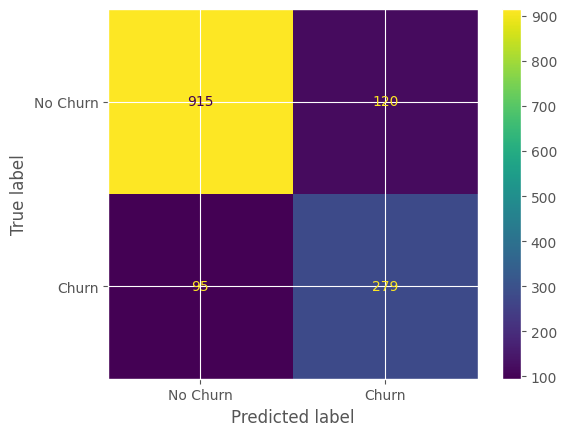

In [64]:
# Let's take a look at the confusion matrix for our predictions
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Churn', 'Churn'])
disp.plot()

In [65]:
# Let's now perform feature selection with recursive feature elimination
from sklearn.feature_selection import RFE

# We will create a feature selection function where we can enter the number of features we want and we get back a list of the n best features
def feature_selection(n_features):
    rfe_selector = RFE(estimator=LGBMClassifier(**best_params), n_features_to_select=n_features, step=10, verbose=5)
    rfe_selector.fit(X_train_enc, y_train)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X_train_enc.loc[:,rfe_support].columns.tolist()
    return rfe_feature


In [66]:
len(X_train_enc.columns)

42

In [67]:
# Fit the model with less features
feature_list = [5,10,15,20,25,30,35,38] #5,10,15,20,25,
results = {}
for num_features in feature_list:
    print('-'*50, f"Number of features: {num_features}",'-'*50)
    
    # Find top n features
    rfe_feature = feature_selection(num_features)
          
    # Subset X_train_enc and X_test_enc with these features
    X_train_enc_trimmed = X_train_enc[rfe_feature]
    X_test_enc_trimmed = X_test_enc[rfe_feature]
    
    # Fit the model 
    clf = LGBMClassifier(objective="binary",
                         n_estimators=20000,
                         learning_rate=0.01,
                         random_state=42)

    eval_set = [(X_test_enc_trimmed, y_test)]

    clf.fit(X_train_enc_trimmed,
            y_train,
            eval_set=eval_set,
            callbacks=[lightgbm.early_stopping(stopping_rounds=200)],
            eval_metric="cross_entropy_lambda")

    y_pred = clf.predict(X_test_enc_trimmed)
    f1 = f1_score(y_test, y_pred)
          
    results[f"{num_features}"] = {'f1':f1, 'features': rfe_feature}

results

-------------------------------------------------- Number of features: 5 --------------------------------------------------
Fitting estimator with 42 features.
[LightGBM] [Warning] lambda_l1 is set=3.3442898556214415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3442898556214415
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.784
[LightGBM] [Warning] lambda_l2 is set=0.3238567153719767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3238567153719767


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fitting estimator with 32 features.


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fitting estimator with 22 features.


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fitting estimator with 12 features.


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[432]	valid_0's cross_entropy_lambda: 0.460974	valid_0's binary_logloss: 0.484901
-------------------------------------------------- Number of features: 10 --------------------------------------------------
Fitting estimator with 42 features.
[LightGBM] [Warning] lambda_l1 is set=3.3442898556214415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3442898556214415
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.784
[LightGBM] [Warning] lambda_l2 is set=0.3238567153719767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3238567153719767


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fitting estimator with 32 features.


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fitting estimator with 22 features.


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fitting estimator with 12 features.


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[456]	valid_0's cross_entropy_lambda: 0.386063	valid_0's binary_logloss: 0.381552
-------------------------------------------------- Number of features: 15 --------------------------------------------------
Fitting estimator with 42 features.
[LightGBM] [Warning] lambda_l1 is set=3.3442898556214415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3442898556214415
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.784
[LightGBM] [Warning] lambda_l2 is set=0.3238567153719767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3238567153719767


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fitting estimator with 32 features.


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fitting estimator with 22 features.


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[429]	valid_0's cross_entropy_lambda: 0.381802	valid_0's binary_logloss: 0.368881
-------------------------------------------------- Number of features: 20 --------------------------------------------------
Fitting estimator with 42 features.
[LightGBM] [Warning] lambda_l1 is set=3.3442898556214415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3442898556214415
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.784
[LightGBM] [Warning] lambda_l2 is set=0.3238567153719767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3238567153719767


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fitting estimator with 32 features.


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fitting estimator with 22 features.


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[441]	valid_0's cross_entropy_lambda: 0.372015	valid_0's binary_logloss: 0.354966
-------------------------------------------------- Number of features: 25 --------------------------------------------------
Fitting estimator with 42 features.
[LightGBM] [Warning] lambda_l1 is set=3.3442898556214415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3442898556214415
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.784
[LightGBM] [Warning] lambda_l2 is set=0.3238567153719767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3238567153719767


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fitting estimator with 32 features.


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[504]	valid_0's cross_entropy_lambda: 0.361311	valid_0's binary_logloss: 0.340392
-------------------------------------------------- Number of features: 30 --------------------------------------------------
Fitting estimator with 42 features.
[LightGBM] [Warning] lambda_l1 is set=3.3442898556214415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3442898556214415
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.784
[LightGBM] [Warning] lambda_l2 is set=0.3238567153719767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3238567153719767


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fitting estimator with 32 features.


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[444]	valid_0's cross_entropy_lambda: 0.363188	valid_0's binary_logloss: 0.342695
-------------------------------------------------- Number of features: 35 --------------------------------------------------
Fitting estimator with 42 features.
[LightGBM] [Warning] lambda_l1 is set=3.3442898556214415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3442898556214415
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.784
[LightGBM] [Warning] lambda_l2 is set=0.3238567153719767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3238567153719767


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[458]	valid_0's cross_entropy_lambda: 0.363417	valid_0's binary_logloss: 0.342928
-------------------------------------------------- Number of features: 38 --------------------------------------------------
Fitting estimator with 42 features.
[LightGBM] [Warning] lambda_l1 is set=3.3442898556214415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3442898556214415
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.784
[LightGBM] [Warning] lambda_l2 is set=0.3238567153719767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3238567153719767


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[479]	valid_0's cross_entropy_lambda: 0.363488	valid_0's binary_logloss: 0.3427


{'5': {'f1': 0.6004728132387707,
  'features': ['ss__Longitude',
   'ss__Monthly_Charges',
   'ss__Total_Charges',
   'ss__CLTV',
   'ss__Churn_%_by_tenure']},
 '10': {'f1': 0.6798516687268233,
  'features': ['ohe__Gender_Male',
   'ss__Latitude',
   'ss__Longitude',
   'ss__Tenure_Months',
   'ss__Monthly_Charges',
   'ss__Total_Charges',
   'ss__CLTV',
   'ss__Churn_%_by_city',
   'ss__Churn_%_by_tenure',
   'ss__Churn_%_by_payment_method']},
 '15': {'f1': 0.6894803548795945,
  'features': ['ohe__Gender_Male',
   'ss__Latitude',
   'ss__Longitude',
   'ss__Tenure_Months',
   'ss__Monthly_Charges',
   'ss__Total_Charges',
   'ss__CLTV',
   'ss__Churn_%_by_city',
   'ss__Churn_%_by_tenure',
   'ss__Churn_%_by_payment_method',
   'remainder__Senior_Citizen',
   'remainder__Partner',
   'remainder__Online_Security',
   'remainder__Tech_Support',
   'remainder__Paperless_Billing']},
 '20': {'f1': 0.6940874035989718,
  'features': ['ohe__Gender_Male',
   'ss__Latitude',
   'ss__Longitude',

<Figure size 640x480 with 0 Axes>

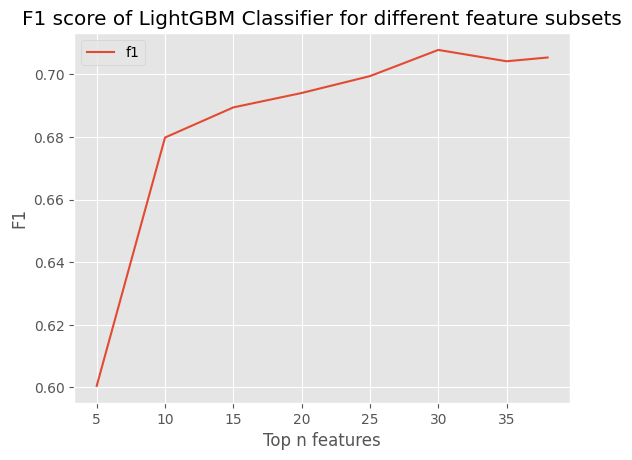

In [68]:
# Plot the f1 scores with the number of features
def plot_feature_graph(results, f1_list, feature_list):
    f1_list = [value['f1'] for key, value in results.items()]
    feature_dataframe = pd.DataFrame({'f1':f1_list, 'num_features':feature_list})
    plt.figure()
    ax = feature_dataframe.plot(kind='line', x='num_features', y='f1')
    ax.set_xlabel('Top n features')
    ax.set_ylabel('F1')
    ax.set_title('F1 score of LightGBM Classifier for different feature subsets')
    plt.show()
    
plot_feature_graph(results, f1_list, feature_list)

In [69]:
# Subset the optimum 30
X_train_enc_trimmed = X_train_enc[feature_selection(30)]
X_test_enc_trimmed = X_test_enc[feature_selection(30)]

Fitting estimator with 42 features.
[LightGBM] [Warning] lambda_l1 is set=3.3442898556214415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3442898556214415
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.784
[LightGBM] [Warning] lambda_l2 is set=0.3238567153719767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3238567153719767


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fitting estimator with 32 features.


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fitting estimator with 42 features.


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fitting estimator with 32 features.


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [70]:
# Tune hyperparameters for lightgbm model using the lightgbm tuner for the optimised feature subset
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, f1_score


dtrain = lgb.Dataset(X_train_enc_trimmed, y_train)
dval = lgb.Dataset(X_test_enc_trimmed, y_test)

params = {
    "objective": "binary",
    "metric": "cross_entropy_lambda",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "random_state":42
}

model = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    callbacks=[early_stopping(100), log_evaluation(100)])

prediction = np.rint(model.predict(X_test_enc_trimmed, num_iteration=model.best_iteration))
f1 = f1_score(y_test, prediction)
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
auc = roc_auc_score(y_test, prediction)
acc = accuracy_score(y_test, prediction)

best_params = model.params
print("Best params:", best_params)
print("  F1 Score = {}".format(f1))
print("  Precision = {}".format(precision))
print("  Recall = {}".format(recall))
print("  AUC = {}".format(auc))
print("  Accuracy = {}".format(acc))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))


[I 2023-05-25 14:40:05,328] A new study created in memory with name: no-name-9b89f7c3-4af5-4e13-b368-1f21221f3811
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's cross_entropy_lambda: 0.323793	valid_1's cross_entropy_lambda: 0.370715


feature_fraction, val_score: 0.361374:  14%|#4        | 1/7 [00:01<00:08,  1.41s/it]

Early stopping, best iteration is:
[44]	valid_0's cross_entropy_lambda: 0.371466	valid_1's cross_entropy_lambda: 0.361374
[100]	valid_0's cross_entropy_lambda: 0.335062	valid_1's cross_entropy_lambda: 0.368021


feature_fraction, val_score: 0.361374:  29%|##8       | 2/7 [00:02<00:07,  1.47s/it]

Early stopping, best iteration is:
[44]	valid_0's cross_entropy_lambda: 0.371466	valid_1's cross_entropy_lambda: 0.361374
[100]	valid_0's cross_entropy_lambda: 0.327438	valid_1's cross_entropy_lambda: 0.370745


feature_fraction, val_score: 0.361374:  43%|####2     | 3/7 [00:04<00:05,  1.40s/it]

Early stopping, best iteration is:
[44]	valid_0's cross_entropy_lambda: 0.371466	valid_1's cross_entropy_lambda: 0.361374
[100]	valid_0's cross_entropy_lambda: 0.32473	valid_1's cross_entropy_lambda: 0.369225


feature_fraction, val_score: 0.360947:  57%|#####7    | 4/7 [00:05<00:04,  1.41s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.329826	valid_1's cross_entropy_lambda: 0.370517


feature_fraction, val_score: 0.360947:  71%|#######1  | 5/7 [00:07<00:02,  1.45s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.325055	valid_1's cross_entropy_lambda: 0.373693


feature_fraction, val_score: 0.360947:  86%|########5 | 6/7 [00:08<00:01,  1.47s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.332905	valid_1's cross_entropy_lambda: 0.370157


feature_fraction, val_score: 0.360947: 100%|##########| 7/7 [00:10<00:00,  1.47s/it]


Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947


num_leaves, val_score: 0.360947:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	valid_0's cross_entropy_lambda: 0.250305	valid_1's cross_entropy_lambda: 0.403178


num_leaves, val_score: 0.360947:   5%|5         | 1/20 [00:04<01:22,  4.34s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.260927	valid_1's cross_entropy_lambda: 0.397917


num_leaves, val_score: 0.360947:  10%|#         | 2/20 [00:08<01:10,  3.94s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.243735	valid_1's cross_entropy_lambda: 0.412663


num_leaves, val_score: 0.360947:  15%|#5        | 3/20 [00:13<01:22,  4.83s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.31971	valid_1's cross_entropy_lambda: 0.371046


num_leaves, val_score: 0.360947:  20%|##        | 4/20 [00:15<00:56,  3.51s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.236818	valid_1's cross_entropy_lambda: 0.437362


num_leaves, val_score: 0.360947:  25%|##5       | 5/20 [00:22<01:11,  4.78s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.237236	valid_1's cross_entropy_lambda: 0.417096


num_leaves, val_score: 0.360947:  30%|###       | 6/20 [00:29<01:16,  5.48s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.240043	valid_1's cross_entropy_lambda: 0.415964


num_leaves, val_score: 0.360947:  35%|###5      | 7/20 [00:35<01:13,  5.62s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.239927	valid_1's cross_entropy_lambda: 0.418376


num_leaves, val_score: 0.360947:  40%|####      | 8/20 [00:41<01:11,  5.97s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.316519	valid_1's cross_entropy_lambda: 0.372988


num_leaves, val_score: 0.360947:  45%|####5     | 9/20 [00:43<00:50,  4.56s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.274183	valid_1's cross_entropy_lambda: 0.384848


num_leaves, val_score: 0.360947:  50%|#####     | 10/20 [00:46<00:40,  4.02s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.258613	valid_1's cross_entropy_lambda: 0.391066


num_leaves, val_score: 0.360947:  55%|#####5    | 11/20 [00:49<00:35,  3.91s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.258613	valid_1's cross_entropy_lambda: 0.391066


num_leaves, val_score: 0.360947:  60%|######    | 12/20 [00:53<00:30,  3.87s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.253481	valid_1's cross_entropy_lambda: 0.399728


num_leaves, val_score: 0.360947:  65%|######5   | 13/20 [00:57<00:27,  3.92s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.273419	valid_1's cross_entropy_lambda: 0.38337


num_leaves, val_score: 0.360947:  70%|#######   | 14/20 [01:00<00:21,  3.59s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.245897	valid_1's cross_entropy_lambda: 0.410414


num_leaves, val_score: 0.360947:  75%|#######5  | 15/20 [01:05<00:19,  3.94s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.236155	valid_1's cross_entropy_lambda: 0.419606


num_leaves, val_score: 0.360947:  80%|########  | 16/20 [01:13<00:20,  5.22s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.277216	valid_1's cross_entropy_lambda: 0.381761


num_leaves, val_score: 0.360947:  85%|########5 | 17/20 [01:16<00:13,  4.44s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947


num_leaves, val_score: 0.360947:  90%|######### | 18/20 [01:16<00:06,  3.26s/it]

[100]	valid_0's cross_entropy_lambda: 0.390911	valid_1's cross_entropy_lambda: 0.364466
Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.241211	valid_1's cross_entropy_lambda: 0.417097


num_leaves, val_score: 0.360947:  95%|#########5| 19/20 [01:21<00:03,  3.88s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.251243	valid_1's cross_entropy_lambda: 0.392293


num_leaves, val_score: 0.360947: 100%|##########| 20/20 [01:26<00:00,  4.31s/it]


Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947


bagging, val_score: 0.360947:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	valid_0's cross_entropy_lambda: 0.323011	valid_1's cross_entropy_lambda: 0.375028


bagging, val_score: 0.360947:  10%|#         | 1/10 [00:01<00:12,  1.40s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.323282	valid_1's cross_entropy_lambda: 0.375961


bagging, val_score: 0.360947:  20%|##        | 2/10 [00:02<00:11,  1.44s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.324014	valid_1's cross_entropy_lambda: 0.37129


bagging, val_score: 0.360947:  30%|###       | 3/10 [00:04<00:10,  1.45s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.327183	valid_1's cross_entropy_lambda: 0.377156


bagging, val_score: 0.360947:  40%|####      | 4/10 [00:05<00:08,  1.44s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.323894	valid_1's cross_entropy_lambda: 0.371271


bagging, val_score: 0.360947:  50%|#####     | 5/10 [00:07<00:07,  1.43s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.327509	valid_1's cross_entropy_lambda: 0.37249


bagging, val_score: 0.360947:  60%|######    | 6/10 [00:08<00:06,  1.50s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.323678	valid_1's cross_entropy_lambda: 0.370887


bagging, val_score: 0.360947:  70%|#######   | 7/10 [00:10<00:04,  1.54s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.328165	valid_1's cross_entropy_lambda: 0.374034


bagging, val_score: 0.360947:  80%|########  | 8/10 [00:11<00:03,  1.53s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.324837	valid_1's cross_entropy_lambda: 0.367958


bagging, val_score: 0.360947:  90%|######### | 9/10 [00:13<00:01,  1.62s/it]

Early stopping, best iteration is:
[50]	valid_0's cross_entropy_lambda: 0.362774	valid_1's cross_entropy_lambda: 0.360947
[100]	valid_0's cross_entropy_lambda: 0.32471	valid_1's cross_entropy_lambda: 0.368961


bagging, val_score: 0.360240: 100%|##########| 10/10 [00:15<00:00,  1.56s/it]


Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352557	valid_1's cross_entropy_lambda: 0.36024


feature_fraction_stage2, val_score: 0.360240:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	valid_0's cross_entropy_lambda: 0.325141	valid_1's cross_entropy_lambda: 0.373823


feature_fraction_stage2, val_score: 0.360240:  17%|#6        | 1/6 [00:02<00:12,  2.45s/it]

Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352557	valid_1's cross_entropy_lambda: 0.36024
[100]	valid_0's cross_entropy_lambda: 0.32471	valid_1's cross_entropy_lambda: 0.368961


feature_fraction_stage2, val_score: 0.360240:  33%|###3      | 2/6 [00:04<00:09,  2.30s/it]

Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352557	valid_1's cross_entropy_lambda: 0.36024
[100]	valid_0's cross_entropy_lambda: 0.32471	valid_1's cross_entropy_lambda: 0.368961


feature_fraction_stage2, val_score: 0.360240:  50%|#####     | 3/6 [00:06<00:06,  2.17s/it]

Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352557	valid_1's cross_entropy_lambda: 0.36024
[100]	valid_0's cross_entropy_lambda: 0.323998	valid_1's cross_entropy_lambda: 0.373008


feature_fraction_stage2, val_score: 0.360240:  67%|######6   | 4/6 [00:08<00:04,  2.07s/it]

Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352557	valid_1's cross_entropy_lambda: 0.36024
[100]	valid_0's cross_entropy_lambda: 0.325898	valid_1's cross_entropy_lambda: 0.372023


feature_fraction_stage2, val_score: 0.360240:  83%|########3 | 5/6 [00:10<00:02,  2.01s/it]

Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352557	valid_1's cross_entropy_lambda: 0.36024
[100]	valid_0's cross_entropy_lambda: 0.324299	valid_1's cross_entropy_lambda: 0.373267


feature_fraction_stage2, val_score: 0.360240: 100%|##########| 6/6 [00:12<00:00,  2.08s/it]


Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352557	valid_1's cross_entropy_lambda: 0.36024


regularization_factors, val_score: 0.360240:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	valid_0's cross_entropy_lambda: 0.324575	valid_1's cross_entropy_lambda: 0.369977


regularization_factors, val_score: 0.360240:   5%|5         | 1/20 [00:02<00:38,  2.02s/it]

Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352557	valid_1's cross_entropy_lambda: 0.36024
[100]	valid_0's cross_entropy_lambda: 0.324694	valid_1's cross_entropy_lambda: 0.368882


regularization_factors, val_score: 0.360240:  10%|#         | 2/20 [00:03<00:35,  1.98s/it]

Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352557	valid_1's cross_entropy_lambda: 0.36024
[100]	valid_0's cross_entropy_lambda: 0.346709	valid_1's cross_entropy_lambda: 0.366356


regularization_factors, val_score: 0.360240:  15%|#5        | 3/20 [00:06<00:34,  2.05s/it]

Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352557	valid_1's cross_entropy_lambda: 0.36024
[100]	valid_0's cross_entropy_lambda: 0.329975	valid_1's cross_entropy_lambda: 0.373054


regularization_factors, val_score: 0.360240:  20%|##        | 4/20 [00:08<00:32,  2.06s/it]

Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352557	valid_1's cross_entropy_lambda: 0.36024
[100]	valid_0's cross_entropy_lambda: 0.360984	valid_1's cross_entropy_lambda: 0.361005


regularization_factors, val_score: 0.360240:  25%|##5       | 5/20 [00:10<00:30,  2.02s/it]

Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352557	valid_1's cross_entropy_lambda: 0.36024
[100]	valid_0's cross_entropy_lambda: 0.324366	valid_1's cross_entropy_lambda: 0.368977


regularization_factors, val_score: 0.360240:  30%|###       | 6/20 [00:12<00:29,  2.08s/it]

Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352558	valid_1's cross_entropy_lambda: 0.36024
[100]	valid_0's cross_entropy_lambda: 0.331703	valid_1's cross_entropy_lambda: 0.369215


regularization_factors, val_score: 0.360240:  35%|###5      | 7/20 [00:14<00:26,  2.05s/it]

Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352558	valid_1's cross_entropy_lambda: 0.36024
[100]	valid_0's cross_entropy_lambda: 0.324297	valid_1's cross_entropy_lambda: 0.372698


regularization_factors, val_score: 0.360240:  40%|####      | 8/20 [00:16<00:24,  2.03s/it]

Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352558	valid_1's cross_entropy_lambda: 0.36024
[100]	valid_0's cross_entropy_lambda: 0.326688	valid_1's cross_entropy_lambda: 0.371555


regularization_factors, val_score: 0.360240:  45%|####5     | 9/20 [00:18<00:22,  2.09s/it]

Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352558	valid_1's cross_entropy_lambda: 0.36024
[100]	valid_0's cross_entropy_lambda: 0.336122	valid_1's cross_entropy_lambda: 0.369767


regularization_factors, val_score: 0.360240:  50%|#####     | 10/20 [00:21<00:22,  2.27s/it]

Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352558	valid_1's cross_entropy_lambda: 0.36024
[100]	valid_0's cross_entropy_lambda: 0.33279	valid_1's cross_entropy_lambda: 0.371683


regularization_factors, val_score: 0.360240:  55%|#####5    | 11/20 [00:23<00:21,  2.38s/it]

Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352558	valid_1's cross_entropy_lambda: 0.36024
[100]	valid_0's cross_entropy_lambda: 0.324741	valid_1's cross_entropy_lambda: 0.369668


regularization_factors, val_score: 0.360240:  60%|######    | 12/20 [00:25<00:17,  2.24s/it]

Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352558	valid_1's cross_entropy_lambda: 0.36024
[100]	valid_0's cross_entropy_lambda: 0.324599	valid_1's cross_entropy_lambda: 0.370148


regularization_factors, val_score: 0.360240:  65%|######5   | 13/20 [00:27<00:14,  2.09s/it]

Early stopping, best iteration is:
[61]	valid_0's cross_entropy_lambda: 0.352558	valid_1's cross_entropy_lambda: 0.36024
[100]	valid_0's cross_entropy_lambda: 0.323657	valid_1's cross_entropy_lambda: 0.369147


regularization_factors, val_score: 0.359912:  70%|#######   | 14/20 [00:29<00:11,  1.97s/it]

Early stopping, best iteration is:
[43]	valid_0's cross_entropy_lambda: 0.373315	valid_1's cross_entropy_lambda: 0.359912
[100]	valid_0's cross_entropy_lambda: 0.323838	valid_1's cross_entropy_lambda: 0.374661


regularization_factors, val_score: 0.359912:  75%|#######5  | 15/20 [00:30<00:09,  1.87s/it]

Early stopping, best iteration is:
[43]	valid_0's cross_entropy_lambda: 0.373315	valid_1's cross_entropy_lambda: 0.359912
[100]	valid_0's cross_entropy_lambda: 0.323981	valid_1's cross_entropy_lambda: 0.371574


regularization_factors, val_score: 0.359912:  80%|########  | 16/20 [00:32<00:07,  1.85s/it]

Early stopping, best iteration is:
[43]	valid_0's cross_entropy_lambda: 0.373315	valid_1's cross_entropy_lambda: 0.359912
[100]	valid_0's cross_entropy_lambda: 0.323981	valid_1's cross_entropy_lambda: 0.371574


regularization_factors, val_score: 0.359912:  85%|########5 | 17/20 [00:34<00:05,  1.85s/it]

Early stopping, best iteration is:
[43]	valid_0's cross_entropy_lambda: 0.373315	valid_1's cross_entropy_lambda: 0.359912
[100]	valid_0's cross_entropy_lambda: 0.3241	valid_1's cross_entropy_lambda: 0.374081


regularization_factors, val_score: 0.359912:  90%|######### | 18/20 [00:36<00:03,  1.86s/it]

Early stopping, best iteration is:
[43]	valid_0's cross_entropy_lambda: 0.373315	valid_1's cross_entropy_lambda: 0.359912
[100]	valid_0's cross_entropy_lambda: 0.324417	valid_1's cross_entropy_lambda: 0.371831


regularization_factors, val_score: 0.359912:  95%|#########5| 19/20 [00:38<00:01,  1.84s/it]

Early stopping, best iteration is:
[43]	valid_0's cross_entropy_lambda: 0.373315	valid_1's cross_entropy_lambda: 0.359912
[100]	valid_0's cross_entropy_lambda: 0.324692	valid_1's cross_entropy_lambda: 0.368397


regularization_factors, val_score: 0.359912: 100%|##########| 20/20 [00:40<00:00,  2.01s/it]


Early stopping, best iteration is:
[43]	valid_0's cross_entropy_lambda: 0.373315	valid_1's cross_entropy_lambda: 0.359912


min_data_in_leaf, val_score: 0.359912:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	valid_0's cross_entropy_lambda: 0.327448	valid_1's cross_entropy_lambda: 0.370802


min_data_in_leaf, val_score: 0.359912:  20%|##        | 1/5 [00:01<00:07,  1.81s/it]

Early stopping, best iteration is:
[43]	valid_0's cross_entropy_lambda: 0.373315	valid_1's cross_entropy_lambda: 0.359912
[100]	valid_0's cross_entropy_lambda: 0.322176	valid_1's cross_entropy_lambda: 0.372519


min_data_in_leaf, val_score: 0.359912:  40%|####      | 2/5 [00:03<00:05,  1.84s/it]

Early stopping, best iteration is:
[43]	valid_0's cross_entropy_lambda: 0.373315	valid_1's cross_entropy_lambda: 0.359912
[100]	valid_0's cross_entropy_lambda: 0.32172	valid_1's cross_entropy_lambda: 0.370792


min_data_in_leaf, val_score: 0.359912:  60%|######    | 3/5 [00:05<00:03,  1.82s/it]

Early stopping, best iteration is:
[43]	valid_0's cross_entropy_lambda: 0.373315	valid_1's cross_entropy_lambda: 0.359912
[100]	valid_0's cross_entropy_lambda: 0.333898	valid_1's cross_entropy_lambda: 0.365722


min_data_in_leaf, val_score: 0.359685:  80%|########  | 4/5 [00:07<00:01,  1.87s/it]

Early stopping, best iteration is:
[44]	valid_0's cross_entropy_lambda: 0.379954	valid_1's cross_entropy_lambda: 0.359685
[100]	valid_0's cross_entropy_lambda: 0.324745	valid_1's cross_entropy_lambda: 0.37207


min_data_in_leaf, val_score: 0.359685: 100%|##########| 5/5 [00:09<00:00,  1.86s/it]

Early stopping, best iteration is:
[44]	valid_0's cross_entropy_lambda: 0.379954	valid_1's cross_entropy_lambda: 0.359685
Best params: {'objective': 'binary', 'metric': 'cross_entropy_lambda', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 42, 'feature_pre_filter': False, 'lambda_l1': 0.010423851312845367, 'lambda_l2': 0.00054986188632375, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.8630787238726214, 'bagging_freq': 4, 'min_child_samples': 100, 'num_iterations': 1000, 'early_stopping_round': None}
  F1 Score = 0.7084398976982098
  Precision = 0.678921568627451
  Recall = 0.7406417112299465
  AUC = 0.8070358314603839
  Accuracy = 0.8381831085876508
  Params: 
    objective: binary
    metric: cross_entropy_lambda
    verbosity: -1
    boosting_type: gbdt
    random_state: 42
    feature_pre_filter: False
    lambda_l1: 0.010423851312845367
    lambda_l2: 0.00054986188632375
    num_leaves: 31
    feature_fraction: 0.8999999999999999
    bag

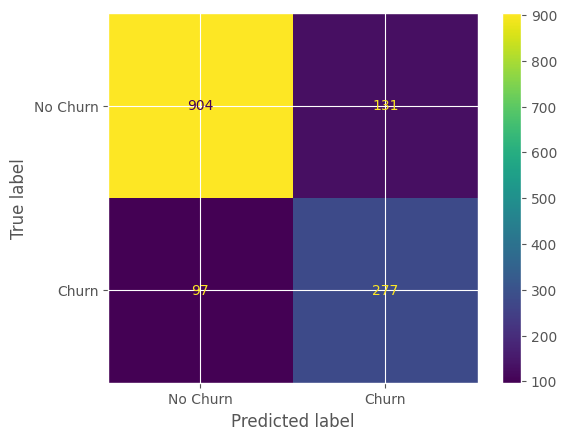

In [71]:
# Let's take a look at the confusion matrix for our predictions
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Churn', 'Churn'])
disp.plot()

In [72]:
# Take a look at the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, labels=[0,1], target_names=['Non-churned', 'Churned']))


              precision    recall  f1-score   support

 Non-churned       0.90      0.88      0.89      1035
     Churned       0.68      0.73      0.71       374

    accuracy                           0.84      1409
   macro avg       0.79      0.80      0.80      1409
weighted avg       0.84      0.84      0.84      1409



## And there we have it

So, to conclude, we predict a total of 1189/ 1409 (accuracy = 84%), 276/374 (recall = 74%), 276/398 (precision = 69%). From a business perspective, the value we want to minimise in our confusion matrix is the bottom left (predicted churn but true lable is no churn). The reason for this is we would rather incorrectly predict a customer to be churning when they are not instead of incorrectly customers to not be churning when in fact they are. This approach means that we will be catching more churners at the small cost of identifying a few non-churners incorreclty as churners.

